# Лабораторная работа №1
# Разведочный анализ датасета исторических данных по фотоэлектричеству и нагрузке

## Задача

Выполнить разведочный анализ датасета с определением:
- типов признаков в датасете;
- пропущенных значений и их устранением;
- выбросов и их устранением;
- расчетом статистических показателей признаков (средних, квартилей и т.д.);
- визуализацией распределения наиболее важных признаков;
- корреляций между признаками.

## Описание датасета

- timestamp - время измерения;
- site_id - номер объекта, с которого брали информацию (0..70);
- period_id - номер периода (?);
- actual_consumption - фактическое потребление энергии;
- actual_pv - фактическое производство фотоэлектрической энергии;
- load_00..load 95 - прогноз потребления на 15 минут вперед вплоть до 24 часов;
- pv_00..pv_95 - прогноз производства на 15 минут вперед вплоть до 24 часов.

## 1. Подготовка ноутбука

### Импорт модулей

In [1]:
#Импорт модулей, не связанных с PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from functools import reduce

#Импорт PySpark
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains, array \
, isnan, udf, hour, array_min, array_max, countDistinct, count, when, max, stddev, avg, log
from pyspark.sql.types import *
from pyspark.ml.stat import Correlation

### Инициализация сессии PySpark

In [2]:
#Инициализация сессии PySpark
MAX_MEMORY = '15G'

conf = pyspark.SparkConf().setMaster("local[10]") \
        .set("spark.executor.heartbeatInterval", 10000) \
        .set("spark.network.timeout", 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

### Настройка ноутбука

In [3]:
#Позволяет отображать все результаты выполнения ячейки, а не только последний
InteractiveShell.ast_node_interactivity = "all" 
#Позволяет отображать графики прямо в ячейках ноутбука, а не в отдельном окне
%matplotlib inline

### Загрузка датасета

In [4]:
#Создание списка путей к файлам с числовой последовательностью
file_paths = ["data/{}.csv".format(i) for i in range(1, 16)]

#Чтение всех CSV файлов из списка в DataFrame
df = spark.read.option("delimiter", ";").csv(file_paths, header=True, mode="DROPMALFORMED")
print("Data frame type: " + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


## 2. Просмотр датасета

Посмотрим на некоторые столбцы, содержащиеся в датасете, и на их тип

In [5]:
print("Columns overview")
pd.DataFrame(df.dtypes, columns = ["Column Name", "Data type"])

Columns overview


Column Name Data type
0             timestamp    string
1               site_id    string
2             period_id    string
3    actual_consumption    string
4             actual_pv    string
..                  ...       ...
192               pv_91    string
193               pv_92    string
194               pv_93    string
195               pv_94    string
196               pv_95    string

[197 rows x 2 columns]

Посмотрим сколько всего строк в датасете

In [11]:
print(f"There are total {df.count()} row")

There are total 962282 row


Выведем первую строку для понимания содержания датасета

In [7]:
print("Let print first row:")
df.limit(1).toPandas().T

Let print first row:


0
timestamp           2014-07-19T18:45:00+00:00
site_id                                     1
period_id                                   0
actual_consumption          51.62570299494799
actual_pv                   22.71248932566911
...                                       ...
pv_91                      51.999027777293456
pv_92                       43.29092055293084
pv_93                       34.16134295173217
pv_94                      28.349900624649297
pv_95                      24.636240602817107

[197 rows x 1 columns]

## 3. Исправление типов данных в датасете

### timestamp
Столбец _timestamp_ преобразуем к типу `timestamp` с игнорированием часового пояса, так как он везде +00:00

In [5]:
df = df.withColumn("timestamp", df["timestamp"].cast(TimestampType()))

### site_id и period_id
Столбцы _site_id_ и _period_id_ преобразуем к типу `integer`

In [6]:
#Список столбцов для изменения типа данных на integer
cols_to_integer_conv = ["site_id", "period_id"]

#Преобразование типа в int
for col_name in cols_to_integer_conv:
    df = df.withColumn(col_name, col(col_name).cast(IntegerType()))

Найдем максимальные значения преобразованных столбцов, чтоб понять, можем ли мы поменять их тип на `byte`. Так как он занимает меньше места в памяти и в теории будет быстрее обрабатываться

In [10]:
#Проверка максимального значения столбца
max_site = df.agg(max("site_id"))
max_period = df.agg(max("period_id"))

max_site.show()
max_period.show()

+------------+
|max(site_id)|
+------------+
|          20|
+------------+

+--------------+
|max(period_id)|
+--------------+
|           120|
+--------------+



Так и есть. Максимальные значения столбцов меньше 127. Меняем тип на `byte`

In [7]:
#Так как максимальное значение меньше 127 и весь столбец положителен, то его можно преобразовать в тип byte
for col_name in cols_to_integer_conv:
    df = df.withColumn(col_name, col(col_name).cast(ByteType()))

### Оставшиеся столбцы
Столбцы _actual_consumption_, _actual_pv_, _load_00..load_95_ и _pv_00..pv_95_ преобразуем к типу `double`

In [8]:
#Список столбцов для изменения типа данных на double
cols_to_double_conv = ["actual_consumption", "actual_pv"] + \
                       ["load_{:02d}".format(i) for i in range(96)] + \
                       ["pv_{:02d}".format(i) for i in range(96)]

#Преобразование типа в double
for col_name in cols_to_double_conv:
    df = df.withColumn(col_name, col(col_name).cast(DoubleType()))

### Проверка преобразования

Выводим столбцы и их типы, а также первую строку датасета

In [13]:
#Проверка преобразования типов
print("Columns overview")
pd.DataFrame(df.dtypes, columns = ["Column Name", "Data type"])

Columns overview


Column Name  Data type
0             timestamp  timestamp
1               site_id    tinyint
2             period_id    tinyint
3    actual_consumption     double
4             actual_pv     double
..                  ...        ...
192               pv_91     double
193               pv_92     double
194               pv_93     double
195               pv_94     double
196               pv_95     double

[197 rows x 2 columns]

In [14]:
print("Let print first row:")
df.limit(1).toPandas()

Let print first row:


timestamp  site_id  period_id  actual_consumption  actual_pv  \
0 2014-07-19 18:45:00        1          0           51.625703  22.712489   

     load_00    load_01    load_02    load_03    load_04  ...      pv_86  \
0  52.816828  53.501688  54.079161  52.683472  52.590445  ...  81.286349   

       pv_87      pv_88     pv_89      pv_90      pv_91      pv_92      pv_93  \
0  77.580181  58.433449  55.57297  53.792765  51.999028  43.290921  34.161343   

       pv_94      pv_95  
0  28.349901  24.636241  

[1 rows x 197 columns]

## 4. Обнаружение и устранение пропущенных значений

В PySpark `None` == `null`, поэтому проверяем только `NaN` и `None`. При этом `Timestamp` не может быть `NaN`. Также для _period_id_ `0` - это __действительное значение__ (номер первого периода), тогда как для всех остальных - __отсутствующее__

Подсчитываем количество пропущенных значений для каждого столбца

In [9]:
null_values = {} 

null_count = df.where(col("timestamp").isNull()).count()
null_values.update({"timestamp": null_count})

null_count = df.where(col("period_id").isNull() | isnan(col("period_id"))).count()
null_values.update({"period_id": null_count})

cols_to_check = [col_name for col_name in df.columns 
                 if col_name not in ["timestamp", "period_id"]]
for column in cols_to_check:
    null_count = df.where(col(column).isNull() | isnan(col(column)) | (col(column) == 0)).count()
    null_values.update({column: null_count})

null_df = pd.DataFrame.from_dict([null_values])

max_rows_value = pd.get_option("display.max_rows")
pd.set_option("display.max_rows", None)
null_df.iloc[0][null_df.iloc[0] > 0].T
pd.set_option("display.max_rows", max_rows_value)

actual_pv    489527
load_00           2
load_02           1
load_07           1
load_08           2
load_09           2
load_10           2
load_11           1
load_12           3
load_13           4
load_14           7
load_15          16
load_16           2
Name: 0, dtype: int64

Столбцы _timestamp_ и _period_id_ не имеют пропущенных значений, значит мы можем обработать оставшиеся столбцы одним условием на поиск `0`, `null` и `NaN`

In [10]:
cols_to_check = [column for column in null_df.columns if null_df[column].iloc[0] > 0]

for column in cols_to_check:
    df = df.where(~(col(column).isin([0, np.nan])) & col(column).isNotNull())

Проверяем удаление, снова подсчитывая количество пропущенных значений в столбцах, в которых они были

In [11]:
print(f"There are total {df.count()} row")

There are total 472740 row


In [17]:
#Проверим удаление
null_values = {} 

for column in cols_to_check:
    null_count = df.where(col(column).isin([0, None, np.nan])).count()
    null_values.update({column: null_count})

null_df = pd.DataFrame.from_dict([null_values])

pd.set_option("display.max_rows", None)
null_df.iloc[0][null_df.iloc[0] > 0].T
pd.set_option("display.max_rows", max_rows_value)

Series([], Name: 0, dtype: int64)

## 5. Расчет статистических показаний признаков

Выведем статистические данные по столбцам

In [18]:
summary_df = df.summary().toPandas()

#Выбираем столбцы, начиная со второго, так как первый - это описание
numeric_cols = summary_df.columns[1:]
#Преобразуем к числовому типу
summary_df[numeric_cols] = summary_df[numeric_cols].apply(pd.to_numeric)

#Округляем только числовые значения
summary_df[numeric_cols] = summary_df[numeric_cols].round(2)

pd.set_option("display.max_rows", None)
summary_df.T
pd.set_option("display.max_rows", max_rows_value)

0       1       2       3      4       5       6  \
summary                count    mean  stddev     min    25%     50%     75%   
site_id             636927.0   10.86    5.63     1.0    6.0    11.0    16.0   
period_id           636927.0    45.7   31.77     0.0   18.0    43.0    70.0   
actual_consumption  636927.0  123.09  105.43    0.15  23.22  109.51  194.37   
actual_pv           636927.0   111.1  130.75     0.0  11.14   54.35  181.09   
load_00             636927.0  123.04  104.06 -192.41  23.11  112.49  194.44   
load_01             636927.0  122.87  103.19 -223.89   23.2  113.48  194.42   
load_02             636927.0  122.55  102.44 -185.54   23.3  113.68   194.1   
load_03             636927.0  122.14  101.76 -181.98   23.2  113.64  193.59   
load_04             636927.0  121.65  101.17 -213.68   23.1  113.28  193.05   
load_05             636927.0  121.08  100.59 -224.23  22.96  112.85  192.37   
load_06             636927.0  120.41   100.0  -221.2  22.78  112.26  191.45   
load_07             636927.0  119.66   99.39 -212.76  22.58  111.53   190.4   
load_08             636927.0  118.86   98.79  -204.1  22.45  110.59  189.22   
load_09             636927.0  117.99   98.16 -195.71  22.24  109.63  187.86   
load_10             636927.0  117.07   97.51 -190.09   22.0  108.55  186.47   
load_11             636927.0  116.12   96.82 -182.19  21.74  107.51  184.92   
load_12             636927.0  115.13   96.12 -174.53  21.26  106.46  183.38   
load_13             636927.0  114.12    95.4  -167.1  20.97  105.35  181.91   
load_14             636927.0  113.08   94.64 -162.64  20.67  104.22   180.1   
load_15             636927.0  112.03   93.87 -155.97   20.4  103.17  178.13   
load_16             636927.0  110.97   93.08 -149.02  20.12  102.14  175.96   
load_17             636927.0   109.9   92.22 -142.28  19.83  101.26   173.5   
load_18             636927.0  108.81   91.38 -138.27  19.52  100.31  171.11   
load_19             636927.0  107.72   90.52 -131.93  19.21    99.5  168.79   
load_20             636927.0  106.62   89.64 -125.79  18.95   98.76  166.61   
load_21             636927.0  105.52   88.74 -119.82  18.67   98.07   164.4   
load_22             636927.0  104.42   87.82 -114.11  18.37   97.36   162.3   
load_23             636927.0  103.32   86.88 -109.28  18.14   96.62  160.21   
load_24             636927.0  102.22   85.93 -103.84  17.88   95.95  158.01   
load_25             636927.0  101.13   84.95   -98.7  17.45   95.33   156.0   
load_26             636927.0  100.04   83.96  -95.39  16.99   94.79   154.2   
load_27             636927.0   98.95   82.96  -90.43  16.72   94.19  152.22   
load_28             636927.0   97.88   81.95  -85.61  16.25   93.48  150.25   
load_29             636927.0   96.82   80.95  -81.78  15.77   92.84  148.21   
load_30             636927.0   95.78   79.95  -77.02  15.44   92.38  146.22   
load_31             636927.0   94.75   78.97   -72.6  14.88   91.91  144.27   
load_32             636927.0   93.74   77.97  -68.98   14.4   91.49  142.32   
load_33             636927.0   92.74   76.99  -65.81  13.94   91.02  140.25   
load_34             636927.0   91.77   76.05  -61.65  13.54   90.63  138.22   
load_35             636927.0   90.81   75.12  -59.57  13.19   90.25  136.25   
load_36             636927.0   89.87    74.2  -55.74   12.9   89.82  134.34   
load_37             636927.0   88.94   73.27  -52.03  12.49   89.41  132.47   
load_38             636927.0   88.03   72.37  -48.43  11.98   89.03  130.88   
load_39             636927.0   87.17   71.51  -44.94  11.49   88.62  129.49   
load_40             636927.0   86.35    70.7  -41.56  11.16   88.15  128.32   
load_41             636927.0   85.61   70.02  -38.65  10.96   87.76  127.28   
load_42             636927.0   84.99   69.53   -35.4  10.84   87.41   126.4   
load_43             636927.0   84.46   69.21  -32.24  10.76   87.17  125.61   
load_44             636927.0   84.03    69.0  -29.18  10.73   87.02  124.94  

In [19]:
pd.set_option("display.max_rows", None)
df.summary().toPandas().T
pd.set_option("display.max_rows", max_rows_value)

0                   1                   2  \
summary              count                mean              stddev   
site_id             636927  10.864800832748493  5.6254871815756555   
period_id           636927   45.69730597069994  31.773022858448666   
actual_consumption  636927  123.08834386828667   105.4271282098979   
actual_pv           636927  111.10302584603534  130.75372434025832   
load_00             636927  123.04099978810449  104.05721957585955   
load_01             636927  122.86675663507475  103.19337274265993   
load_02             636927  122.55119607199481  102.43739196108325   
load_03             636927  122.13592377735326  101.75619809377018   
load_04             636927  121.65408447186346  101.17360493604663   
load_05             636927  121.08430253643513  100.58921553519522   
load_06             636927  120.41204468489094   99.99755505753159   
load_07             636927  119.66346087970983    99.3891541817657   
load_08             636927  118.85639248456563   98.79023522593356   
load_09             636927  117.98974732789993   98.16155023916072   
load_10             636927  117.07417232649986   97.50629233646977   
load_11             636927  116.12127651224486   96.81986856919133   
load_12             636927  115.13343048400417   96.11835792998536   
load_13             636927  114.12232272573517   95.39685239924026   
load_14             636927  113.08480416661696   94.64027009975766   
load_15             636927  112.03327108589362   93.86700081973348   
load_16             636927   110.9710407251843   93.07951054603024   
load_17             636927  109.89677953956571   92.21693449795333   
load_18             636927  108.81089886056358   91.38104960294984   
load_19             636927  107.71878389616698   90.52077662868385   
load_20             636927  106.62177217953254   89.63965943488738   
load_21             636927  105.51940260909406   88.73771274102526   
load_22             636927  104.41925359394496   87.81948980838203   
load_23             636927  103.32053306356414   86.88144686281782   
load_24             636927  102.22491546602897   85.92674212500069   
load_25             636927  101.13111244372085   84.95215804128121   
load_26             636927  100.03980240494691   83.96194495874005   
load_27             636927   98.95247279314547   82.95716853974486   
load_28             636927   97.87678375916691   81.94809496477477   
load_29             636927   96.81992483313196   80.94799309309397   
load_30             636927   95.77794016625128    79.9530680165609   
load_31             636927    94.7542962304878   78.96667146242862   
load_32             636927   93.73909237689791   77.97312534945674   
load_33             636927   92.74294577535248   76.99174921800326   
load_34             636927    91.7700618527091   76.04601132068183   
load_35             636927   90.81229167963818   75.11706098220131   
load_36             636927    89.8705626414736   74.19679671178132   
load_37             636927   88.94037562954556   73.27447312701287   
load_38             636927   88.03471148083229   72.36974866001924   
load_39             636927   87.16762113233186   71.50836064193336   
load_40             636927   86.35032162885736   70.69815483894492   
load_41             636927    85.6136317962026   70.02099696356271   
load_42             636927   84.98676997258048   69.53360589631976   
load_43             636927    84.4645549505583    69.2088341461179   
load_44             636927   84.03467200293757   69.00304448681118   
load_45             636927   83.70713138002496   68.93279106805875   
load_46             636927   83.48982400556433    69.0197015593314   
load_47             636927   83.36006741330044    69.2013207415869   
load_48             636927    83.3238625463155   69.48576557050053   
load_49             636927   83.38717701846632   69.87537990370974   
load_50             636927   83.55974225635426   70.34765116234212   
load_51             636927    83.83

По статистическим данным видно, что минимальное значение столбцов _load_xx_ и _pv_xx_  может достигать показателя __меньше нуля__. В контексте их значения - описывать прогноз производства фотоэлектрических панелей и потребления энергии через каждые 15 минут - это __недопустимо__. Нужно удалить отрицательные значения.

In [11]:
cols_to_check = ["pv_{:02d}".format(i) for i in range(96)] + \
                ["load_{:02d}".format(i) for i in range(96)]

for column in cols_to_check:
    df = df.filter(col(column) >= 0)

Проверим удаление

In [ ]:
summary_df = df.summary().toPandas()

#Выбираем столбцы, начиная со второго, так как первый - это описание
numeric_cols = summary_df.columns[1:]
#Преобразуем к числовому типу
summary_df[numeric_cols] = summary_df[numeric_cols].apply(pd.to_numeric)

#Округляем только числовые значения
summary_df[numeric_cols] = summary_df[numeric_cols].round(2)

pd.set_option("display.max_rows", None)
summary_df.T
pd.set_option("display.max_rows", max_rows_value)

In [21]:
pd.set_option("display.max_rows", None)
df.summary().toPandas().T
pd.set_option("display.max_rows", max_rows_value)

0                   1                   2  \
summary              count                mean              stddev   
site_id             303641  10.830740907848414   5.681579776999467   
period_id           303641    44.8116888035542   32.51106919884632   
actual_consumption  303641  124.01581419932326  105.51788125617661   
actual_pv           303641  119.34078463721177   135.7904961573781   
load_00             303641  124.33349365541721  104.43861378207808   
load_01             303641  124.30452763699209  103.74413763720938   
load_02             303641  124.12443613496458   103.1095053422834   
load_03             303641  123.82936020064349     102.53139700718   
load_04             303641  123.46539630929739  102.02974191866083   
load_05             303641  123.00005449919655  101.51596000592896   
load_06             303641  122.42913153493649  100.99162824350061   
load_07             303641  121.77127148140896  100.44993260857623   
load_08             303641  121.06382350072317    99.9124056486354   
load_09             303641  120.27220424286591   99.34527290636753   
load_10             303641   119.4111829565851   98.73449912269447   
load_11             303641  118.50243785105295   98.09272600005947   
load_12             303641  117.55936346482801    97.4372975481129   
load_13             303641  116.58130420898058   96.75728456443711   
load_14             303641  115.54779364068268   96.03992608709439   
load_15             303641  114.49604743436626   95.29564538170466   
load_16             303641  113.41705250181201   94.53318711753975   
load_17             303641  112.31923674247975   93.70116703489282   
load_18             303641  111.21388622062042   92.88279986405145   
load_19             303641  110.10122859797926   92.04192752251033   
load_20             303641  108.97917842323496     91.176652911612   
load_21             303641  107.83707876144646   90.28992431297387   
load_22             303641  106.69114014758706   89.37613071450491   
load_23             303641   105.5400965947777   88.44387983691792   
load_24             303641  104.38702879852063   87.48271509481582   
load_25             303641  103.22904308140555   86.49906464811266   
load_26             303641  102.07304043363806   85.49739646665945   
load_27             303641  100.91452065718353   84.47412455673484   
load_28             303641   99.76632556626616   83.44702125790052   
load_29             303641   98.63365026097051   82.42838092191988   
load_30             303641    97.5183653945291    81.4144963684198   
load_31             303641   96.42048358484519   80.41001155243329   
load_32             303641    95.3284707273929   79.39250914709697   
load_33             303641   94.24248498729581   78.36636256602205   
load_34             303641   93.16906358889857   77.34720138125742   
load_35             303641   92.11206866202608    76.3445052819039   
load_36             303641   91.07092999329883   75.35249979145303   
load_37             303641   90.03601197954495   74.35684598163995   
load_38             303641   89.01700644798416   73.35473607587235   
load_39             303641   88.04181555348043   72.41195518033894   
load_40             303641   87.10868622865372   71.51037221981396   
load_41             303641   86.24369754255915   70.72345972493441   
load_42             303641   85.47273429296844   70.09366927172005   
load_43             303641    84.7987442674521   69.63300064428462   
load_44             303641   84.21429751450906   69.30105739647819   
load_45             303641   83.73878683440392   69.12499188079244   
load_46             303641   83.34693044407732    69.0307563092023   
load_47             303641   83.02722480687902    69.0145698095632   
load_48             303641    82.7851465083563    69.0686420058331   
load_49             303641   82.65951000741853   69.23844177533203   
load_50             303641   82.66152198361753    69.5040927386526   
load_51             303641   82.783

## 6. Визуализация распределения признаков

In [15]:
# Преобразование DataFrame PySpark в Pandas DataFrame
pd_df = df.toPandas()

### timestamp, site_id и period_id

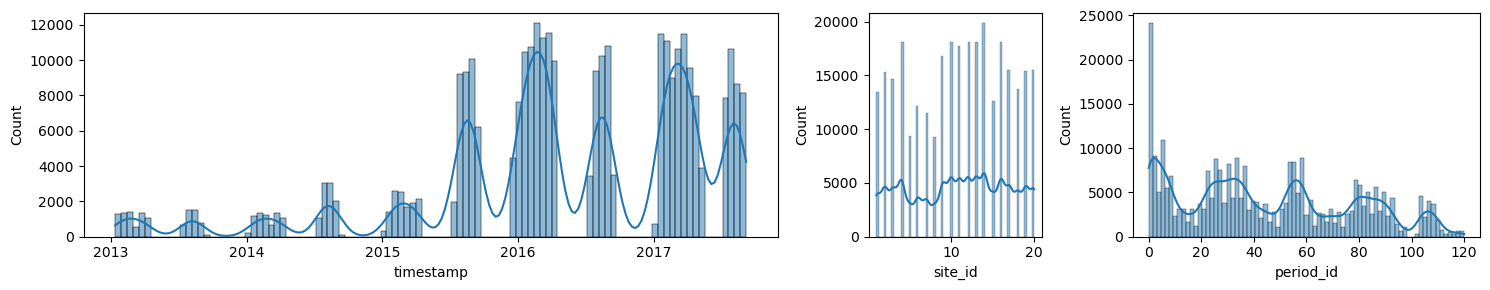

In [22]:
cols_to_check = ["timestamp", "site_id", "period_id"]

# Определение количества строк и столбцов для подграфиков
num_cols = 3
num_rows = 1
# Создание холста с под-графиками для каждого столбца
fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (15, 3), gridspec_kw={'width_ratios': [4, 1, 2]})

for i, column in enumerate(cols_to_check):
    ax = axes[i % num_cols]
    sns.histplot(pd[column], kde = True, ax = ax, label = f"{column}")

plt.tight_layout()
plt.show();

### actual_consumption и load_00..load_95

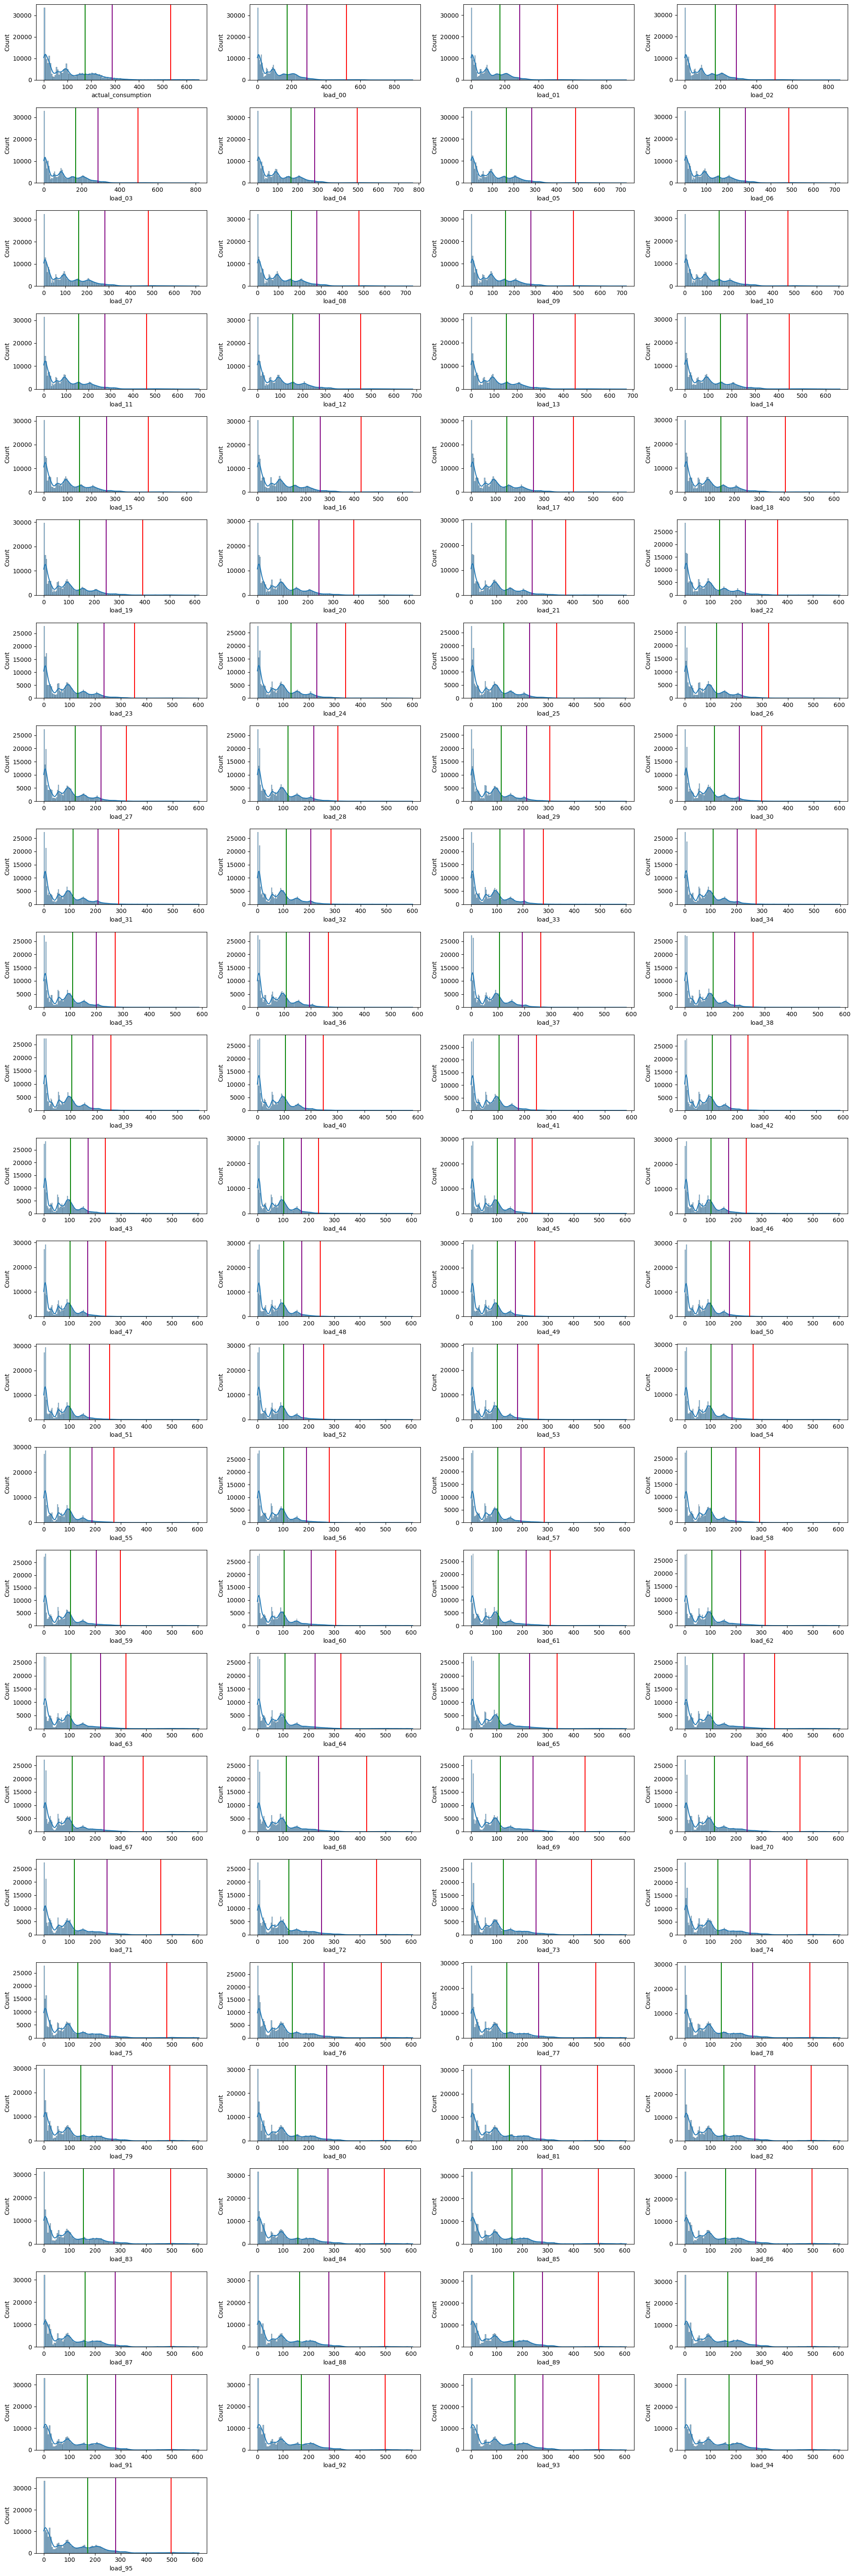

In [24]:
cols_to_check = ["actual_consumption"] + ["load_{:02d}".format(i) for i in range(96)]

# Определение количества строк и столбцов для подграфиков
num_cols = 4
num_rows = math.ceil(len(cols_to_check) / num_cols)
# Создание холста с под-графиками для каждого столбца
fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (20, 60))

for i, column in enumerate(cols_to_check):
    ax = axes[i // num_cols, i % num_cols]
    sns.histplot(pd[column], kde = True, ax = ax, label = f"{column}")
    ax.axvline(pd[column].quantile(0.75), label = "75% quantile", c = "green")
    ax.axvline(pd[column].quantile(0.95), label = "95% quantile", c = "purple")
    ax.axvline(pd[column].quantile(0.99), label = "99% quantile", c = "red")

# Удаление пустых под-графиков, если их количество не кратно num_cols * num_rows
for i in range(len(cols_to_check), num_cols * num_rows):
    fig.delaxes(axes[i // num_cols, i % num_cols])

plt.tight_layout()
plt.show();

Вывод: распределение этих столбцов __близко к экспоненциальному__

### actual_pv и pv_00..pv_95

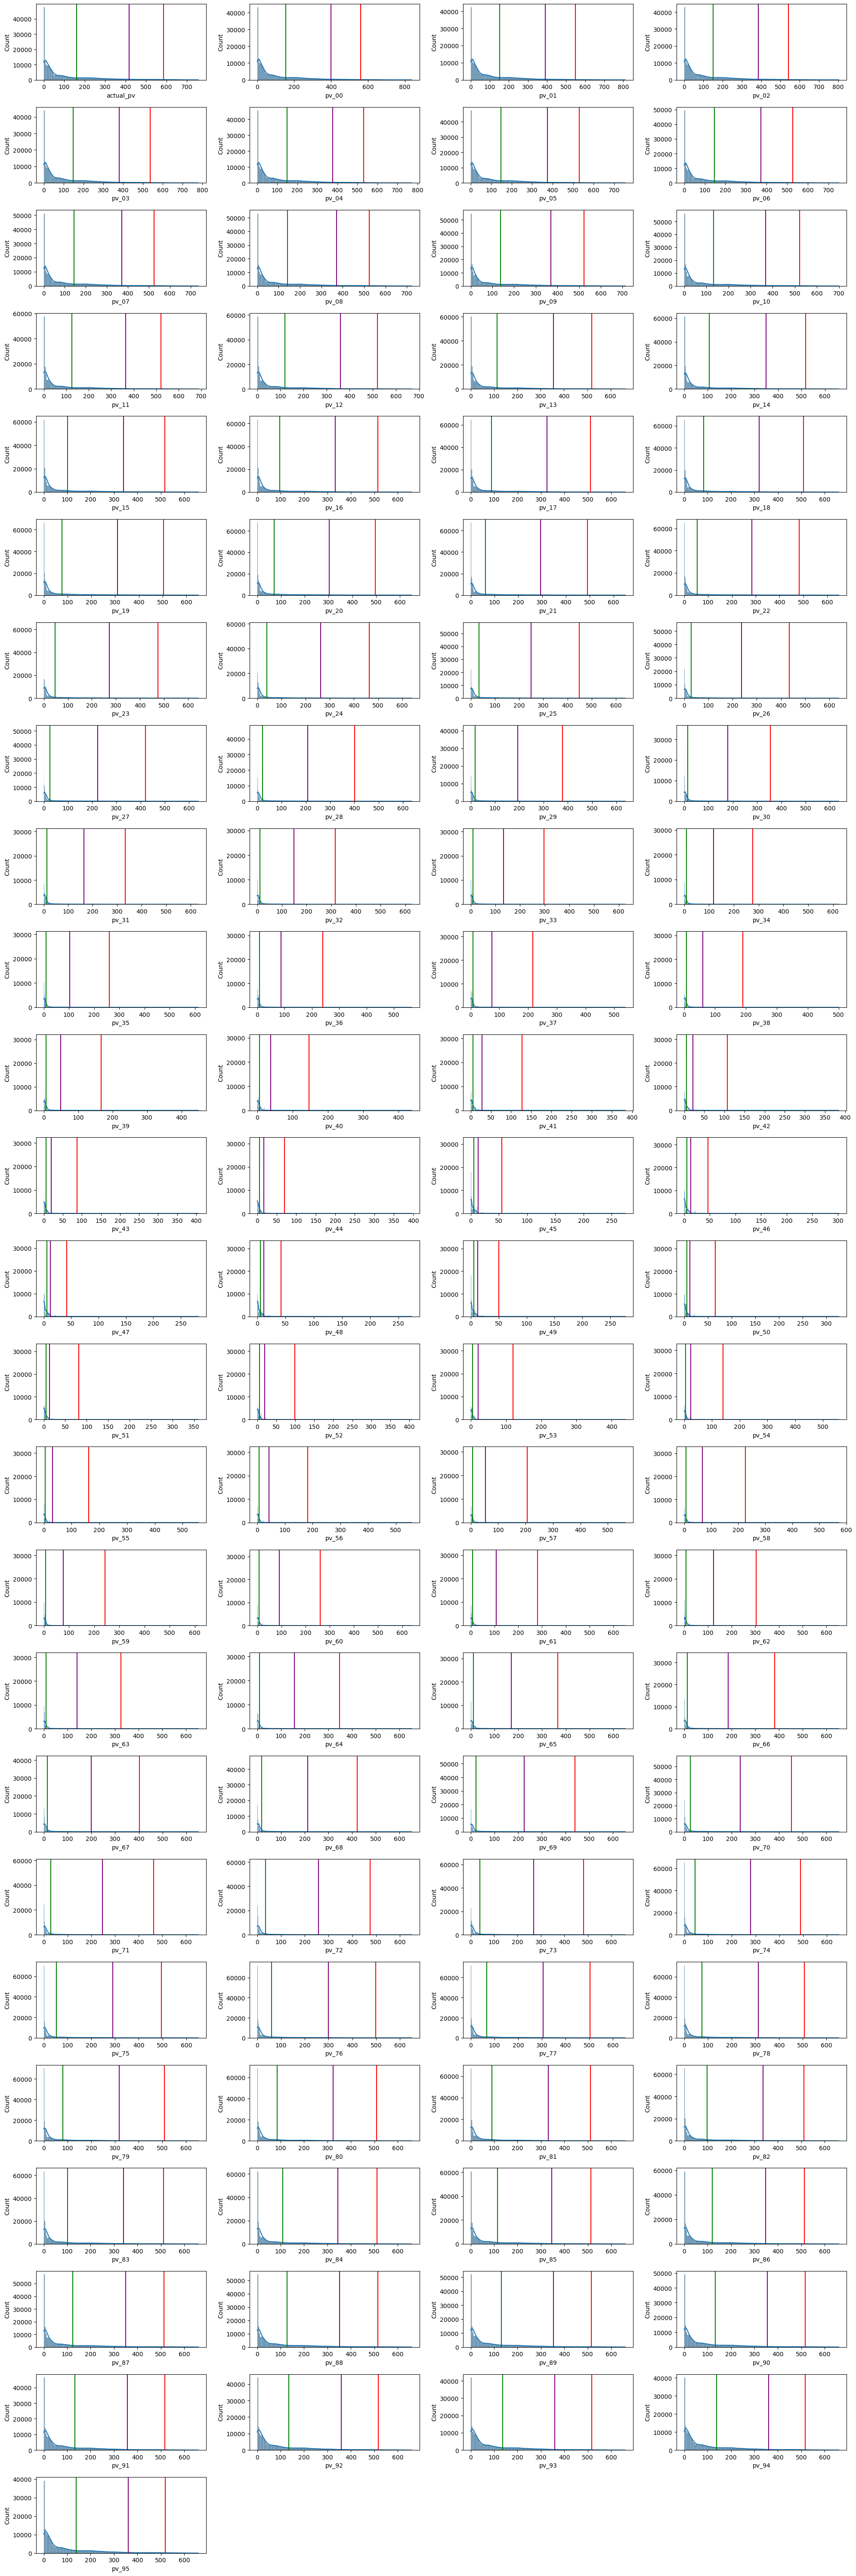

In [22]:
cols_to_check = ["actual_pv"] + ["pv_{:02d}".format(i) for i in range(96)]

# Определение количества строк и столбцов для подграфиков
num_cols = 4
num_rows = math.ceil(len(cols_to_check) / num_cols)
# Создание холста с под-графиками для каждого столбца
fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (20, 60))

for i, column in enumerate(cols_to_check):
    ax = axes[i // num_cols, i % num_cols]
    sns.histplot(pd[column], kde = True, ax = ax, label = f"{column}")
    ax.axvline(pd[column].quantile(0.75), label = "75% quantile", c = "green")
    ax.axvline(pd[column].quantile(0.95), label = "95% quantile", c = "purple")
    ax.axvline(pd[column].quantile(0.99), label = "99% quantile", c = "red")

# Удаление пустых под-графиков, если их количество не кратно num_cols * num_rows
for i in range(len(cols_to_check), num_cols * num_rows):
    fig.delaxes(axes[i // num_cols, i % num_cols])

plt.tight_layout()
plt.show();

Вывод: распределение этих столбцов __экспоненциальное__

## 7. Определение и устранение выбросов

---

In [25]:
# def boxcox_normmax(values):
#     # Преобразование Бокса-Кокса для конкретного lambda
#     def boxcox_transform(x, lmbda):
#         if lmbda == 0:
#             return log(x)
#         else:
#             return (x ** lmbda - 1) / lmbda

#     # UDF для применения функции boxcox_transform к столбцу данных
#     boxcox_udf = udf(lambda x, l: boxcox_transform(x, l), DoubleType())

#     log_udf = udf(lambda x: log(x), DoubleType())
    
#     # Функция правдоподобия для lambda
#     def likelihood_lambda(lmbda):
#         transformed_values = df.withColumn("transformed", boxcox_udf("actual_pv", lit(lmbda)))
#         transformed_values = transformed_values.withColumn("log", log("transformed"))
#         #transformed_values = transformed_values.withColumn("log", log_udf("transformed"))
#         log_likelihood = transformed_values.agg({"log": "sum"}).first()[0]
#         count_transformed_values = transformed_values.count()
#         return -0.5 * count_transformed_values * log_likelihood + (lmbda - 1) * count_transformed_values

#     # Поиск lambda методом оптимизации (например, методом Ньютона)
#     lambda_range = np.linspace(-2, 2, 100)  # диапазон для lambda
#     likelihoods = [likelihood_lambda(l) for l in lambda_range]
#     optimal_lambda = lambda_range[np.argmax(likelihoods)]

#     return optimal_lambda

# # Вычисление оптимального lambda
# optimal_lambda = boxcox_normmax(df.select("actual_pv"))

# print("Optimal Lambda:", optimal_lambda) #-2.0

In [12]:
boxcox_func = lambda x, lmbd: pow(x, lmbd - 1) / lmbd if lmbd != 0 else log(x)
boxcox_udf = udf(boxcox_func, DoubleType())

lambda_val = 1.29  # Устанавливаем значение lambda для преобразования Бокса-Кокса

cols_to_check = ["actual_pv"] + ["pv_{:02d}".format(i) for i in range(96)]

boxcox_columns_expr = [
    boxcox_udf(col(c), lit(lambda_val)).alias(f'{c}_boxcox') if c in cols_to_check else col(c)
    for c in df.columns
]

# Создание нового DataFrame с применением boxcox_udf
boxcox_df = df.select(*boxcox_columns_expr)
boxcox_pd = boxcox_df.toPandas()

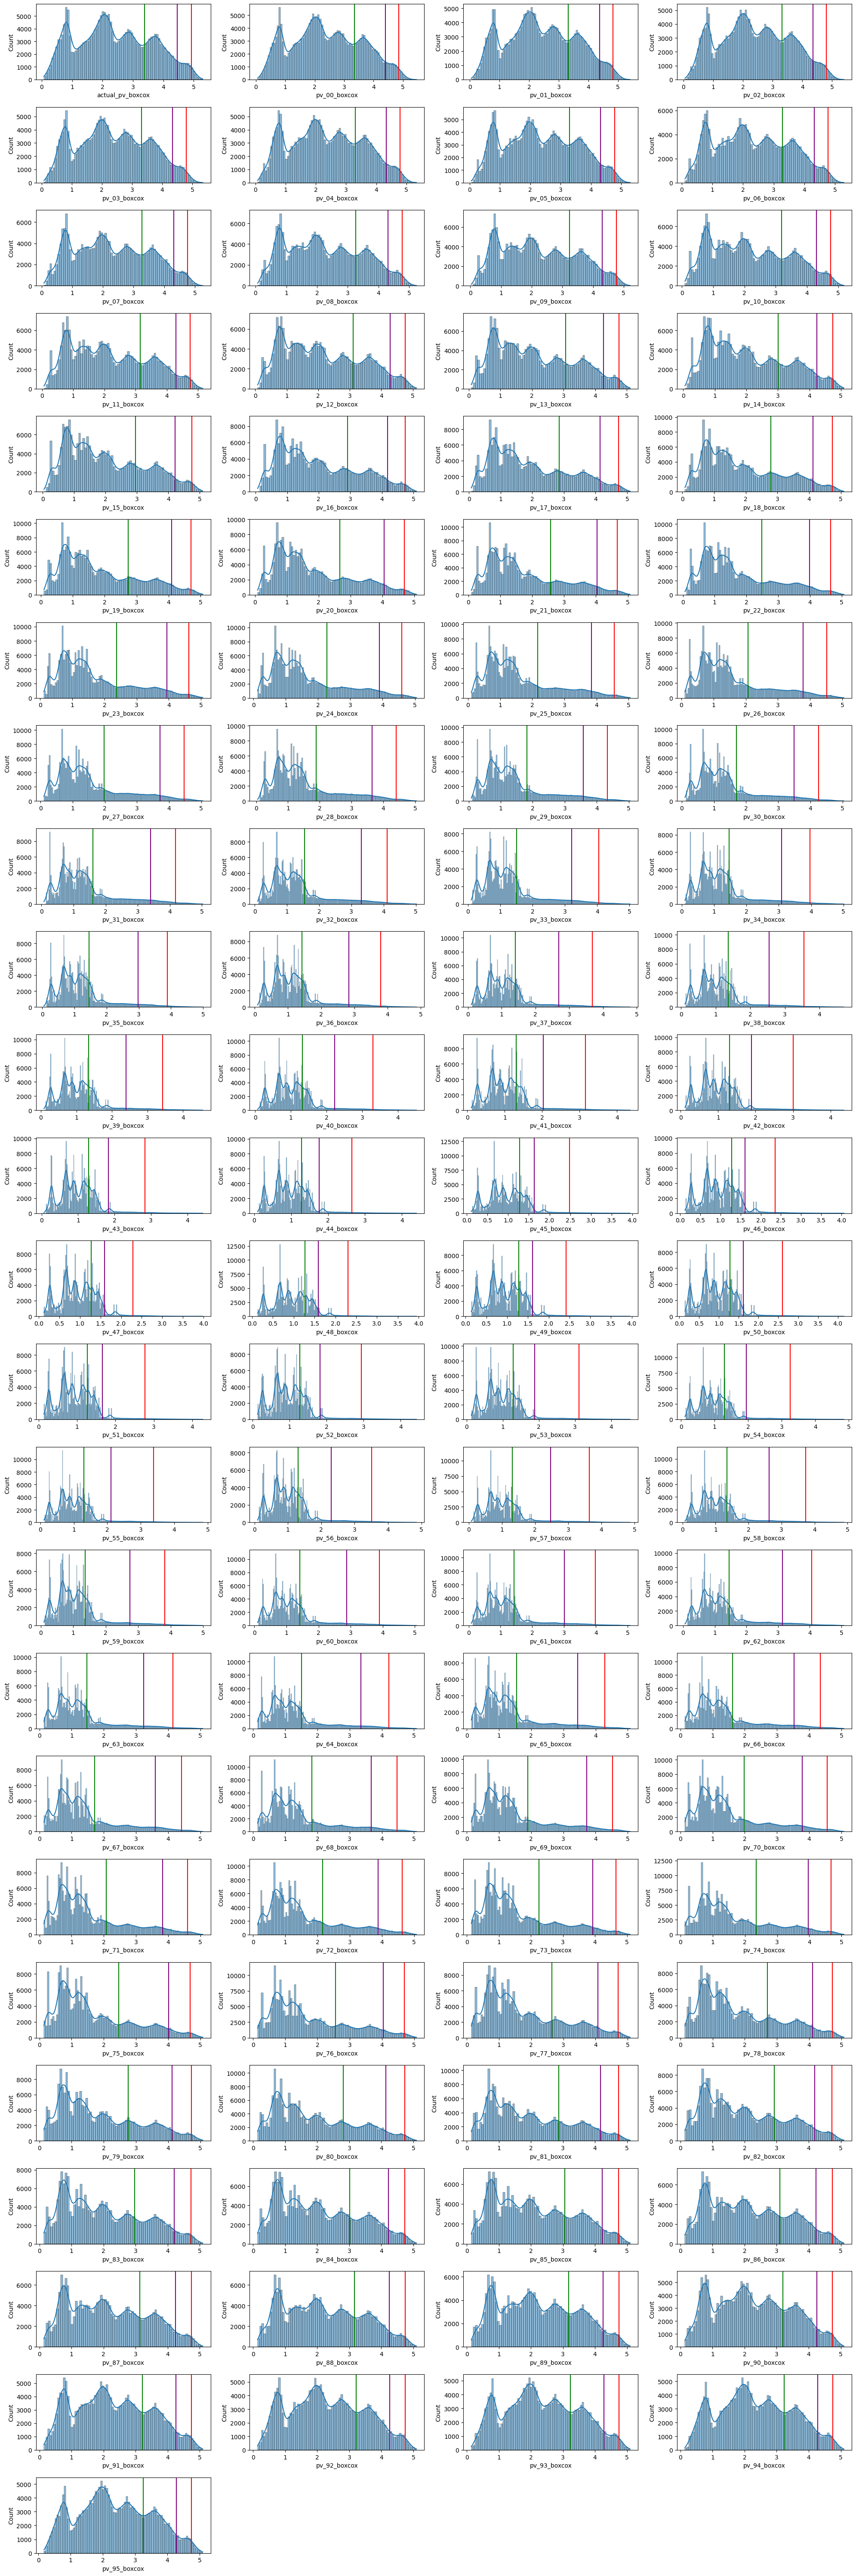

In [13]:
cols_to_check = ["actual_pv_boxcox"] + ["pv_{:02d}_boxcox".format(i) for i in range(96)]
# Определение количества строк и столбцов для подграфиков
num_cols = 4
num_rows = math.ceil(len(cols_to_check) / num_cols)
# Создание холста с под-графиками для каждого столбца
fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (20, 60))

for i, column in enumerate(cols_to_check):
    ax = axes[i // num_cols, i % num_cols]
    sns.histplot(boxcox_pd[column], kde = True, ax = ax, label = f"{column}")
    ax.axvline(boxcox_pd[column].quantile(0.75), label = "75% quantile", c = "green")
    ax.axvline(boxcox_pd[column].quantile(0.95), label = "95% quantile", c = "purple")
    ax.axvline(boxcox_pd[column].quantile(0.99), label = "99% quantile", c = "red")

# Удаление пустых под-графиков, если их количество не кратно num_cols * num_rows
for i in range(len(cols_to_check), num_cols * num_rows):
    fig.delaxes(axes[i // num_cols, i % num_cols])

plt.tight_layout()
plt.show();

In [68]:
cols_to_check = ["actual_pv"] + ["pv_{:02d}".format(i) for i in range(96)]
log_columns_expr = [
    log(col(c)).alias(f'{c}_log') if c in cols_to_check else col(c)
    for c in df.columns
]

# Создание нового DataFrame с применением log
log_df = df.select(*log_columns_expr)
log_pd = log_df.toPandas()

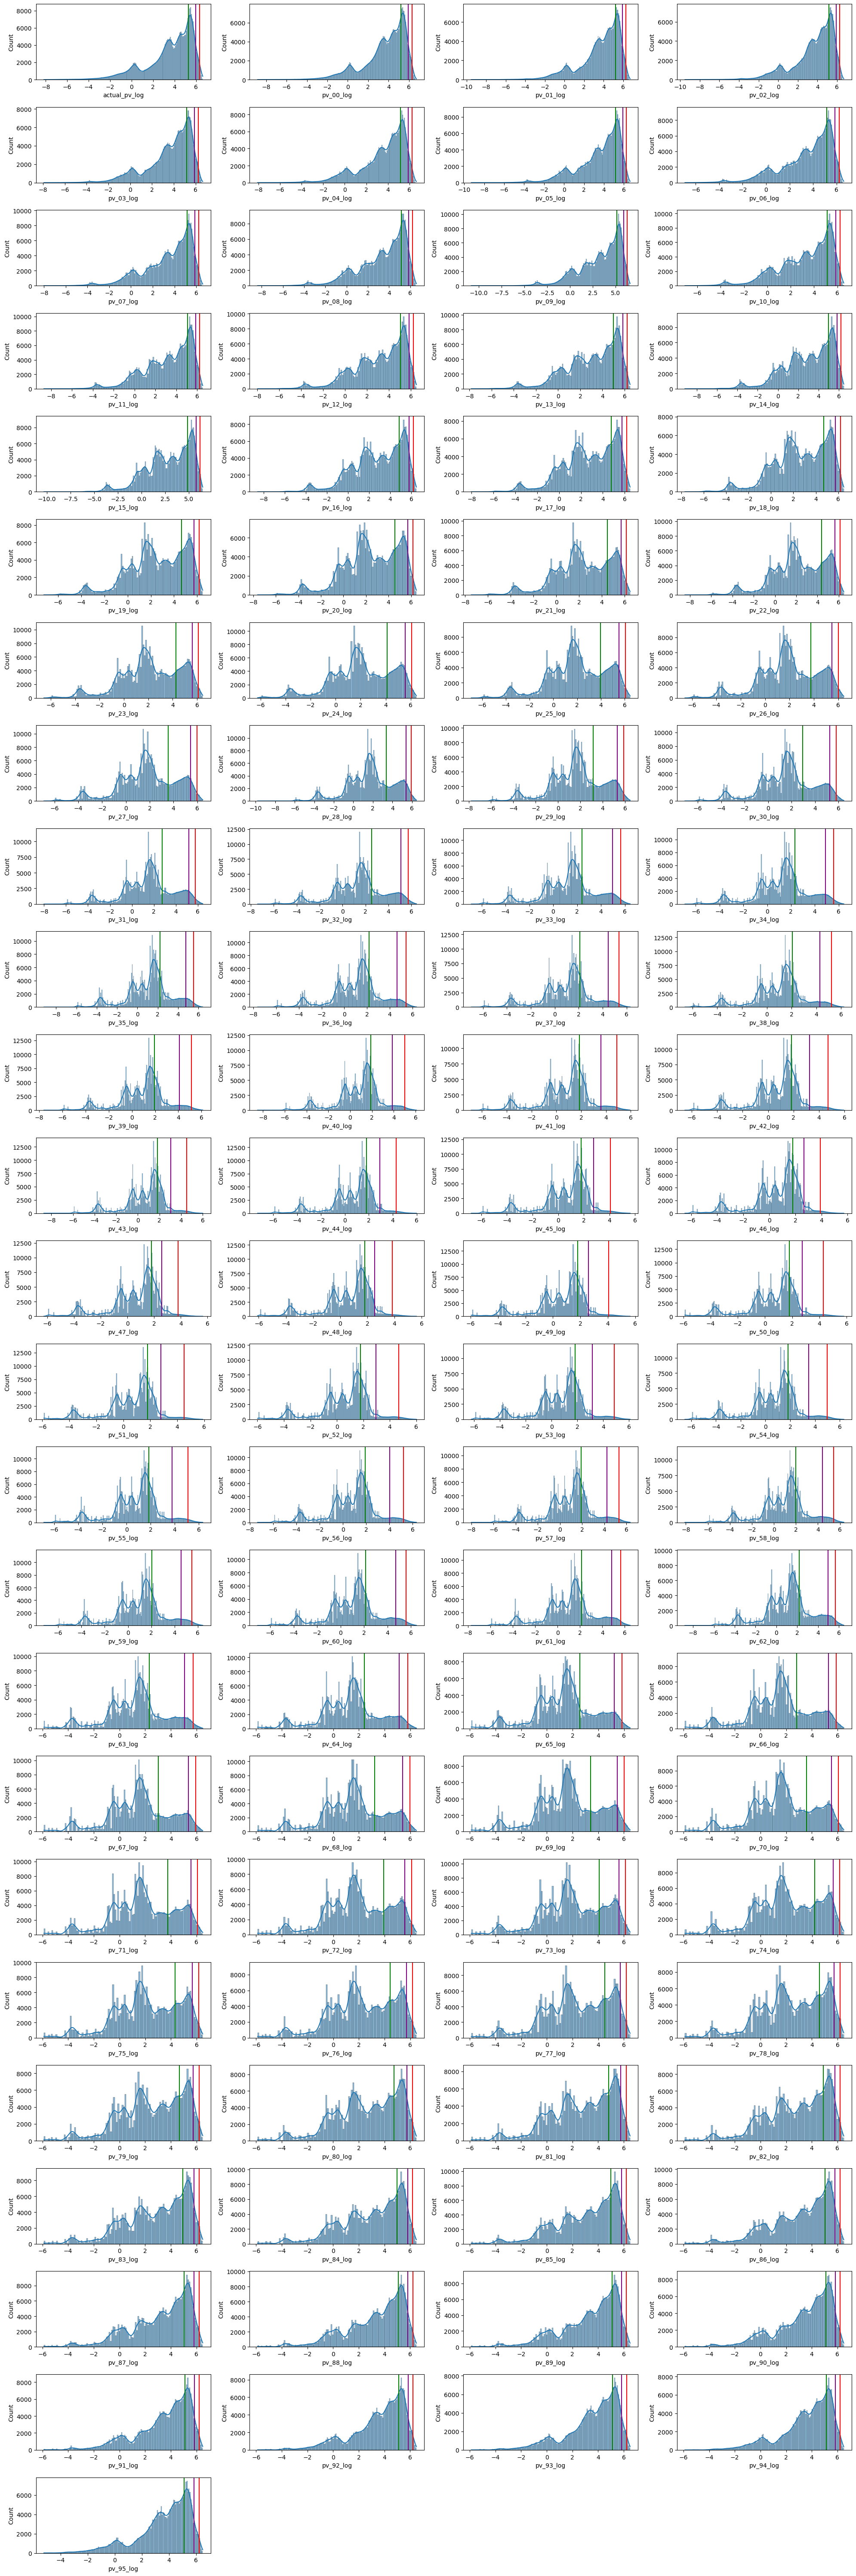

In [74]:
cols_to_check = ["actual_pv_log"] + ["pv_{:02d}_log".format(i) for i in range(96)]
# Определение количества строк и столбцов для подграфиков
num_cols = 4
num_rows = math.ceil(len(cols_to_check) / num_cols)
# Создание холста с под-графиками для каждого столбца
fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (20, 60))

for i, column in enumerate(cols_to_check):
    ax = axes[i // num_cols, i % num_cols]
    sns.histplot(log_pd[column], kde = True, ax = ax, label = f"{column}")
    ax.axvline(log_pd[column].quantile(0.75), label = "90% quantile", c = "green")
    ax.axvline(log_pd[column].quantile(0.95), label = "95% quantile", c = "purple")
    ax.axvline(log_pd[column].quantile(0.99), label = "99% quantile", c = "red")

# Удаление пустых под-графиков, если их количество не кратно num_cols * num_rows
for i in range(len(cols_to_check), num_cols * num_rows):
    fig.delaxes(axes[i // num_cols, i % num_cols])

plt.tight_layout()
plt.show();

---

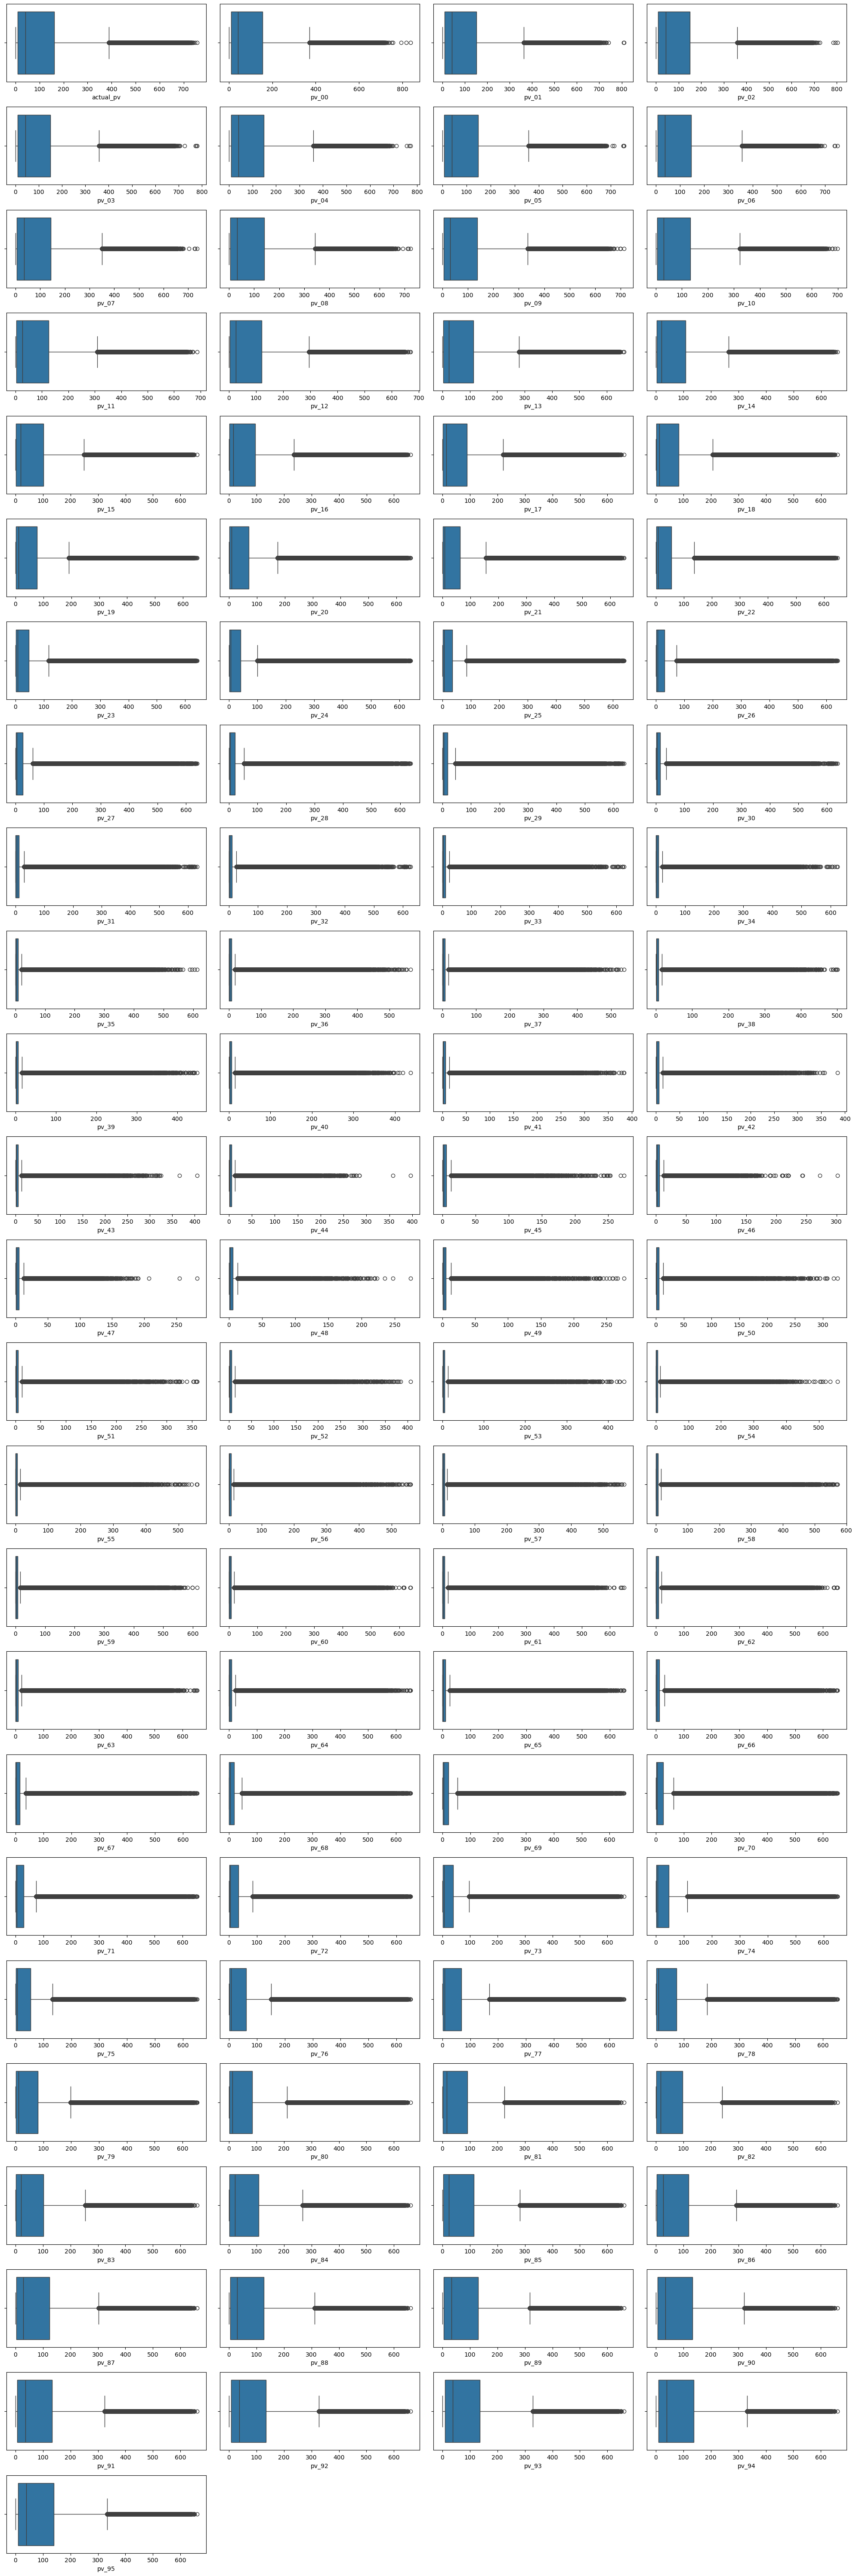

In [16]:
import warnings
warnings.filterwarnings("ignore")

# Определение количества строк и столбцов для подграфиков
num_cols = 4
num_rows = math.ceil(len(cols_to_check) / num_cols)
# Создание холста с под-графиками для каждого столбца
fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (20, 60))

cols_to_check = ["actual_pv"] + ["pv_{:02d}".format(i) for i in range(96)]
for i, column in enumerate(cols_to_check):
    ax = axes[i // num_cols, i % num_cols]
    sns.boxplot(x=pd_df[column], ax=ax, orient='v')

# Удаление пустых под-графиков, если их количество не кратно num_cols * num_rows
for i in range(len(cols_to_check), num_cols * num_rows):
    fig.delaxes(axes[i // num_cols, i % num_cols])

plt.tight_layout()
plt.show();

In [45]:
def iqr_bound(value_list, num_iqr=3):
    Q1, Q3 = sorted(value_list)
    IQR = Q3 - Q1
    lower_bound = Q1 - num_iqr * IQR
    upper_bound = Q3 + num_iqr * IQR
    return [lower_bound, upper_bound]
    
cols_to_check = ["actual_pv"] + ["pv_{:02d}".format(i) for i in range(96)] + \
                ["actual_consumption"] + ["load_{:02d}".format(i) for i in range(96)]
iqr_df = df
for column in cols_to_check:
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    lower_bound, upper_bound = iqr_bound(quantiles)
    iqr_df = iqr_df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

iqr_pd = iqr_df.toPandas()

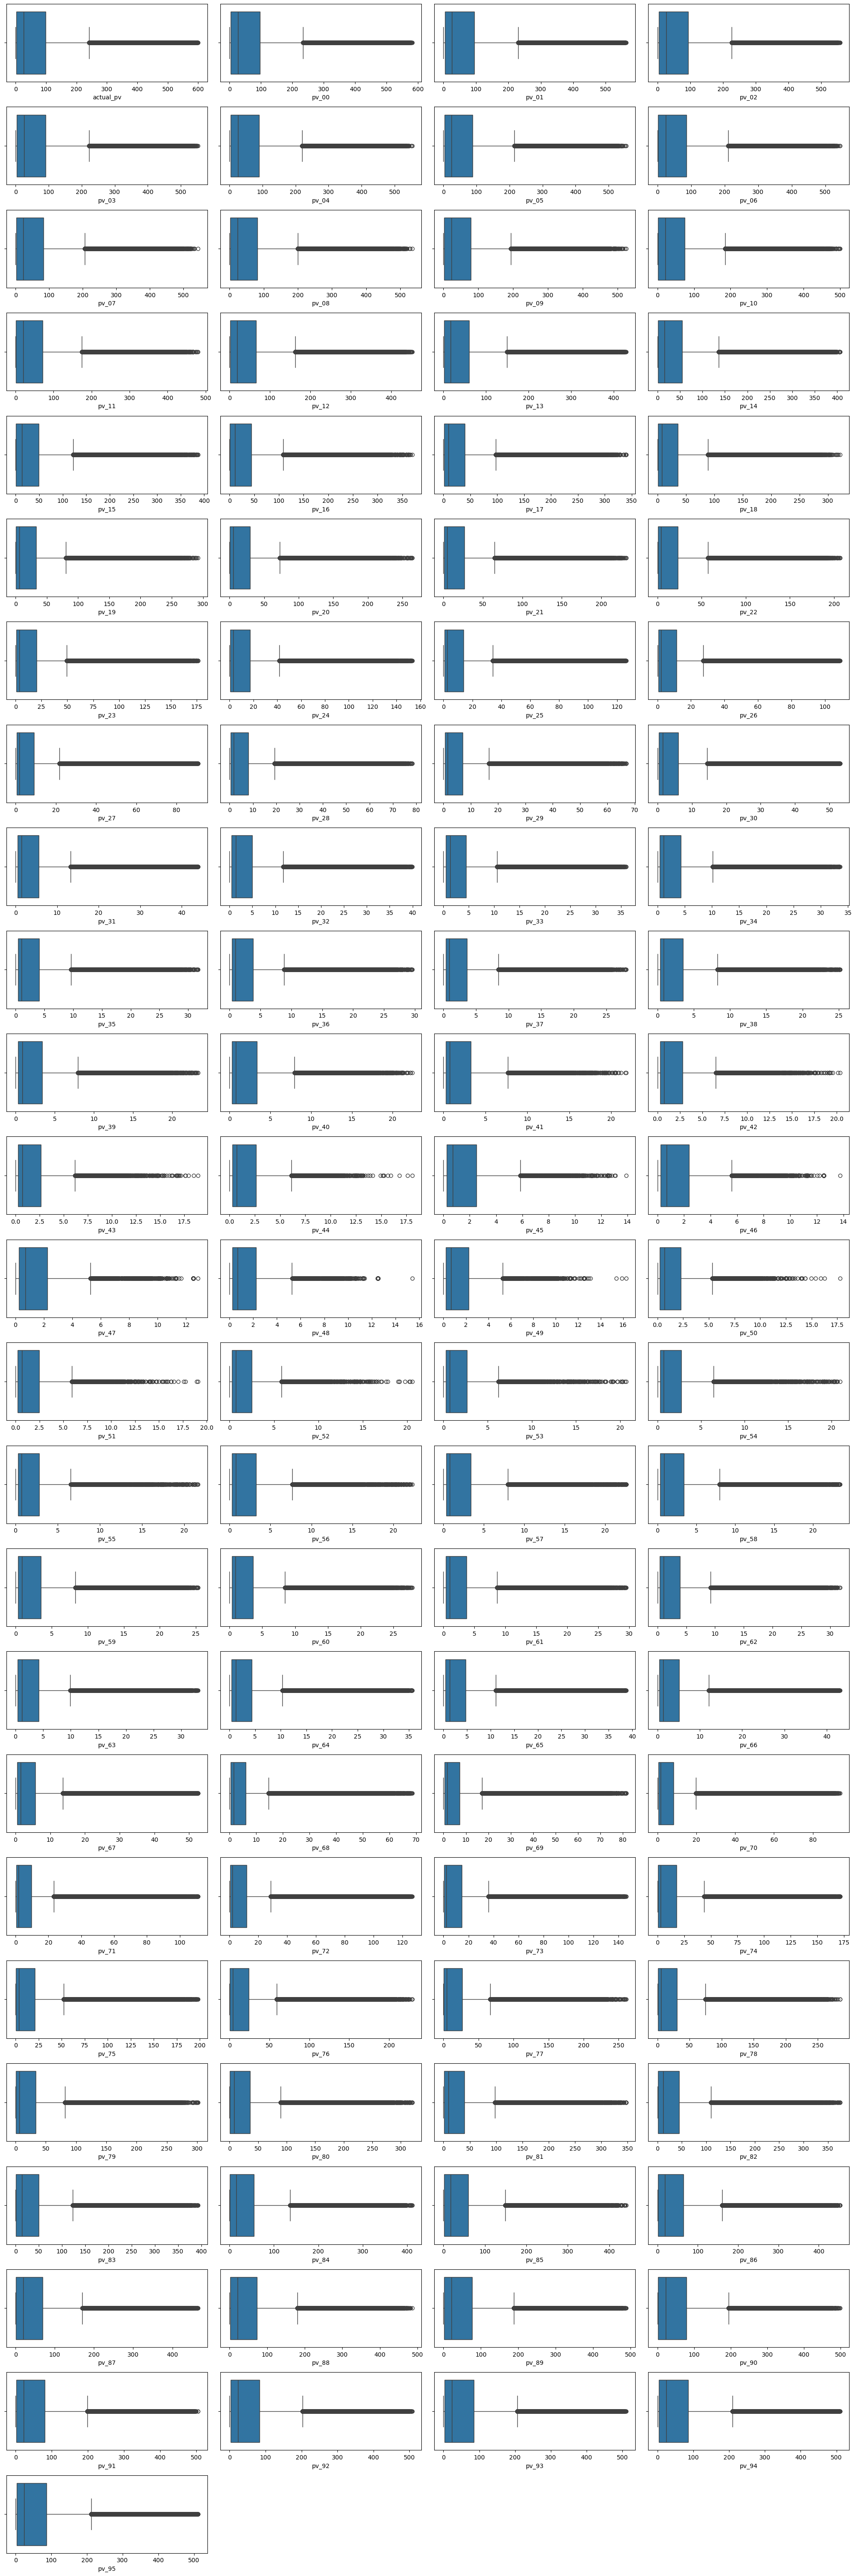

In [47]:
cols_to_check = ["actual_pv"] + ["pv_{:02d}".format(i) for i in range(96)]

# Определение количества строк и столбцов для подграфиков
num_cols = 4
num_rows = math.ceil(len(cols_to_check) / num_cols)
# Создание холста с под-графиками для каждого столбца
fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (20, 60))

for i, column in enumerate(cols_to_check):
    ax = axes[i // num_cols, i % num_cols]
    sns.boxplot(x=iqr_pd[column], ax=ax, orient='v')

# Удаление пустых под-графиков, если их количество не кратно num_cols * num_rows
for i in range(len(cols_to_check), num_cols * num_rows):
    fig.delaxes(axes[i // num_cols, i % num_cols])

plt.tight_layout()
plt.show();

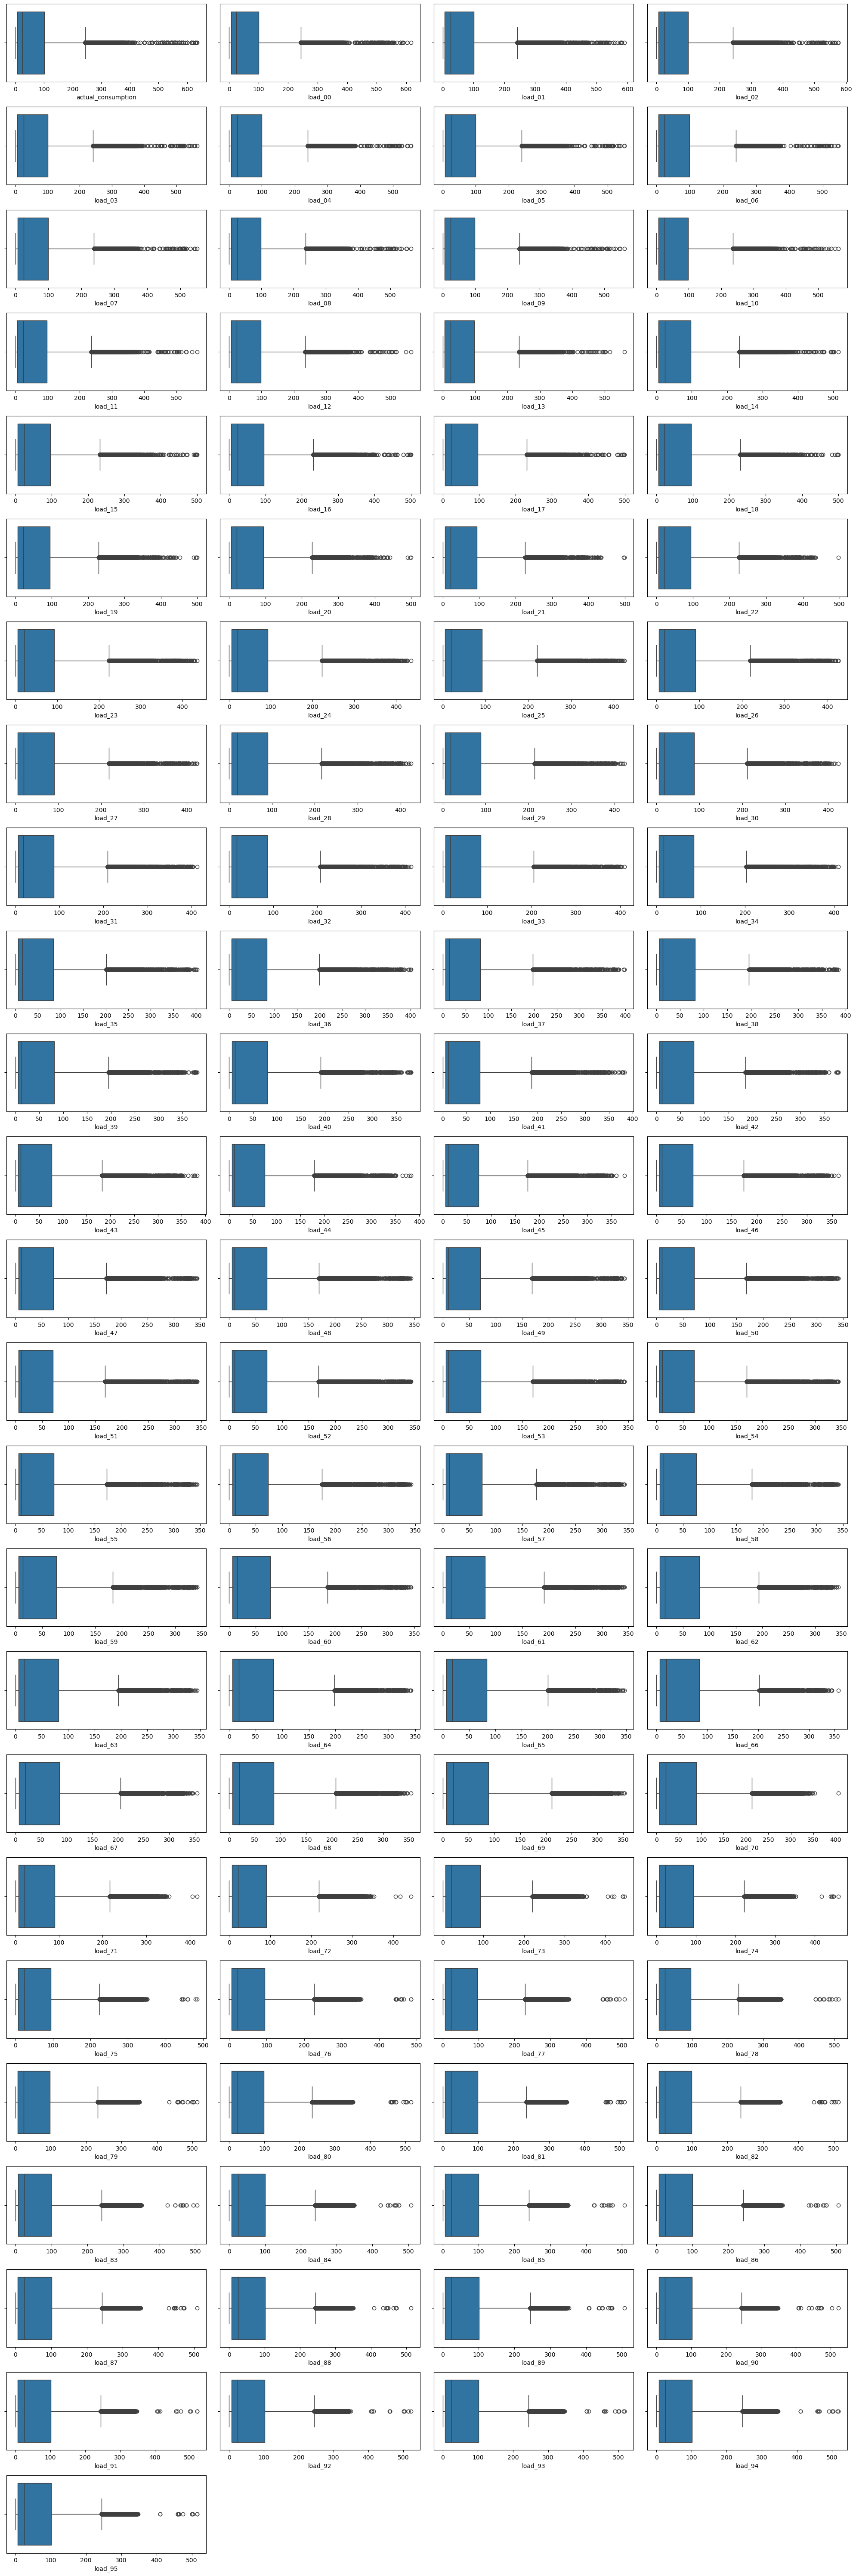

In [46]:
cols_to_check = ["actual_consumption"] + ["load_{:02d}".format(i) for i in range(96)]
                 
# Определение количества строк и столбцов для подграфиков
num_cols = 4
num_rows = math.ceil(len(cols_to_check) / num_cols)
# Создание холста с под-графиками для каждого столбца
fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (20, 60))

for i, column in enumerate(cols_to_check):
    ax = axes[i // num_cols, i % num_cols]
    sns.boxplot(x=iqr_pd[column], ax=ax, orient='v')

# Удаление пустых под-графиков, если их количество не кратно num_cols * num_rows
for i in range(len(cols_to_check), num_cols * num_rows):
    fig.delaxes(axes[i // num_cols, i % num_cols])

plt.tight_layout()
plt.show();

In [50]:
print(f"There are total {iqr_df.count()} row")

There are total 139388 row


---

In [ ]:
# # Правило трех сигм (хорошо работает на нормальном распределении)
# def filter_outliers(df, columns, num_std=3):
#     filtered_data = df
#     for column in columns:
#         # Стандартное отклонение и среднее значение
#         std_dev = df.agg(stddev(col(column))).first()[0]
#         mean_val = df.agg(avg(col(column))).first()[0]

#         # Границы выбросов по правилу трех сигм
#         lower_bound = mean_val - num_std * std_dev
#         upper_bound = mean_val + num_std * std_dev

#         filtered_data = filtered_data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    
#     return filtered_data

# filtered_df = filter_outliers(transformed_df, cols_to_check)

In [ ]:
## Квантили
# excluded_load_99 = set(range(34, 42)) | set(range(54, 59))
# excluded_pv_99 = set(range(17, 45)) | set(range(50, 76))

# cols_quants_99 = ["actual_consumption", "actual_pv"] + \
#                  ["load_{:02d}".format(i) for i in range(96) if i not in excluded_load_99] + \
#                  ["pv_{:02d}".format(i) for i in range(5, 96) if i not in excluded_pv_99]

# cols_quants_95 = ["load_{:02d}".format(i) for i in excluded_load_99] + \
#                  ["pv_{:02d}".format(i) for i in excluded_pv_99]

# #Получение квантилей для разных столбцов
# quants_99 = np.array(df.approxQuantile(cols_quants_99, [0.99], 0.01)).flatten()
# quants_95 = np.array(df.approxQuantile(cols_quants_95, [0.95], 0.01)).flatten()

# #Создание списка условий для фильтрации для каждого столбца
# conditions_99 = []
# for i, column in enumerate(cols_quants_99):
#     # condition = col(column) <= quants_99[i]
#     conditions_99.append(condition)

# conditions_95 = []
# for i, column in enumerate(cols_quants_95):
#     condition = col(column) <= quants_95[i]
#     conditions_95.append(condition)

# # Фильтрация данных с разными ограничениями для разных столбцов
# filtered_df = df.filter(reduce(lambda a, b: a & b, conditions_99))
# filtered_df = df.filter(reduce(lambda a, b: a & b, conditions_95))

---

## 8. Корреляция признаков

In [51]:
# Выбор только столбцов типа Double
double_columns = [c for c, dtype in df.dtypes if dtype == 'double']

# Получение корреляционной матрицы
corr_matrix = iqr_df.select(*double_columns).toPandas().corr()

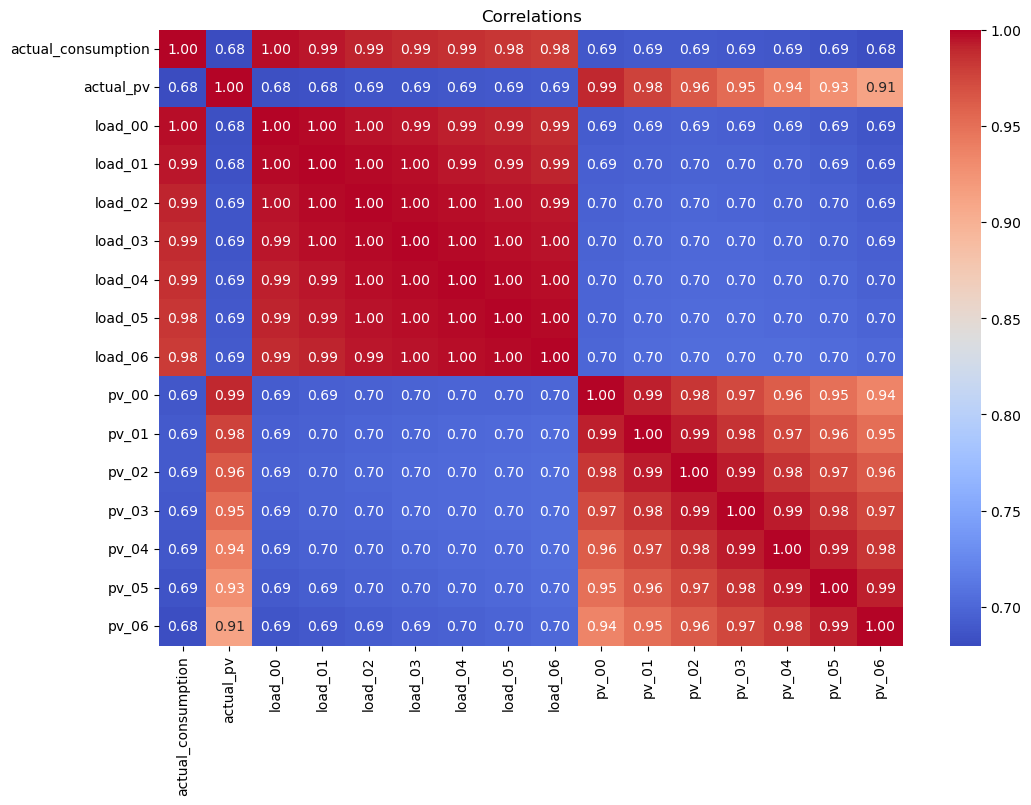

In [52]:
# Извлечение только совпадающих столбцов
target_columns = ['actual_consumption', 'actual_pv', 'load_00', 'load_01',
                  'load_02', 'load_03', 'load_04', 'load_05', 'load_06',
                  'pv_00', 'pv_01', 'pv_02', 'pv_03', 'pv_04', 'pv_05', 'pv_06']
filtered_corr_matrix = corr_matrix[target_columns].loc[target_columns]

# Построение heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlations')
plt.show();

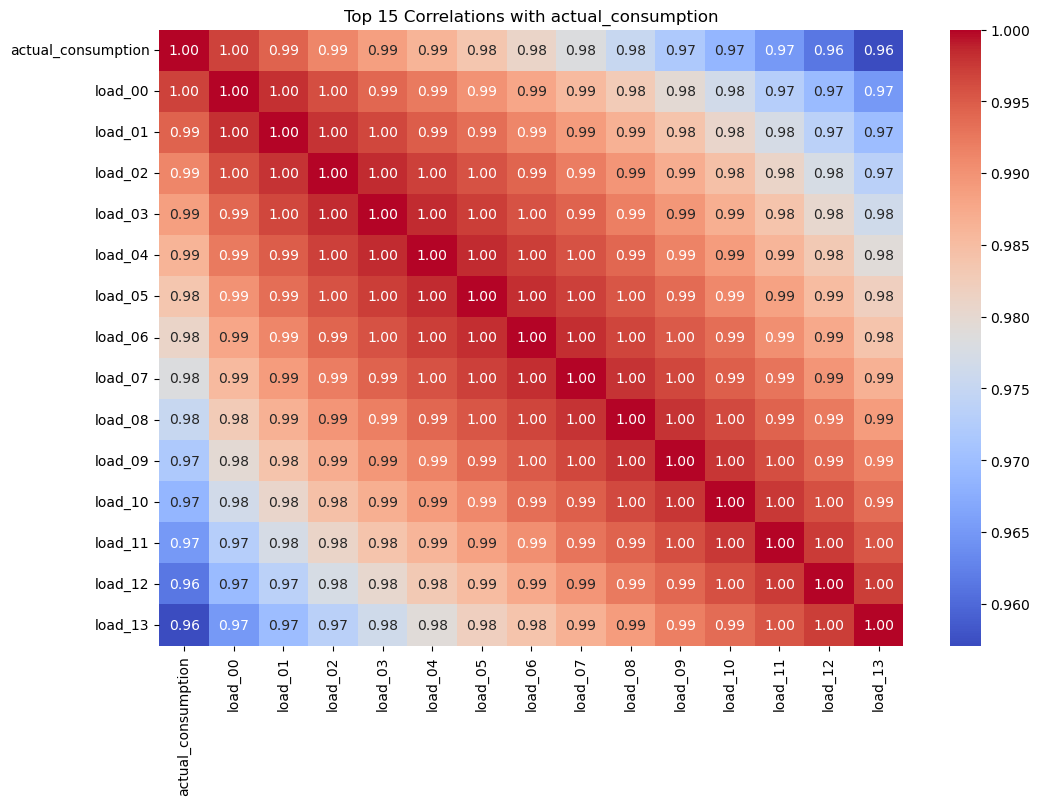

In [53]:
consump_corr_cols = corr_matrix.nlargest(15, "actual_consumption")["actual_consumption"].index.tolist()
top_15_consump_corr = corr_matrix.loc[consump_corr_cols, consump_corr_cols]

# Построение heatmap для топ 15 столбцов
plt.figure(figsize=(12, 8))
sns.heatmap(top_15_consump_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 15 Correlations with actual_consumption')
plt.show();

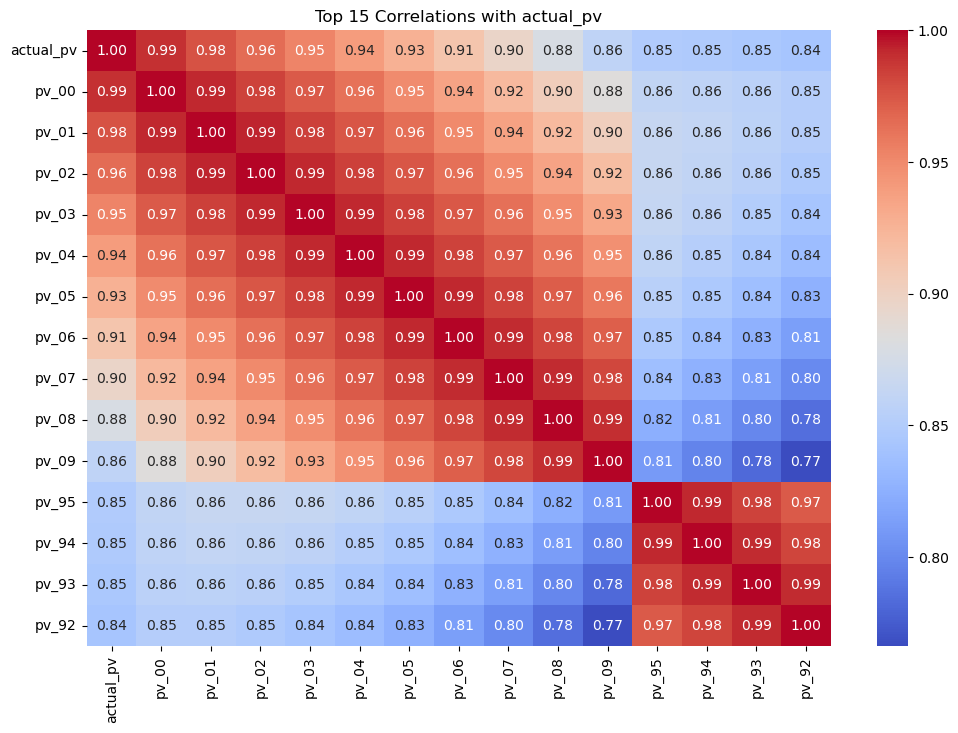

In [55]:
pv_corr_cols = corr_matrix.nlargest(15, "actual_pv")["actual_pv"].index.tolist()
top_15_pv_corr = corr_matrix.loc[pv_corr_cols, pv_corr_cols]

# Построение heatmap для топ 15 столбцов
plt.figure(figsize=(12, 8))
sns.heatmap(top_15_pv_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 15 Correlations with actual_pv')
plt.show();

# Лабораторная работа №2
# Машинное обучение на больших данных

Вариант: 10 mod 4 = __2__

Задача регрессии: __LinearRegression__

Задача бинарной классификации: __GradientBoostingMachine__

## 1. Линейная регрессия (LR)

Первое: проверяем данные на мультиколлинеарность. Если несколько признаков будут сильно связаны между собой, то при изменении одного из них будут меняться и другие, что усложнит оценки их влияния на зависимую переменную

In [63]:
def filter_correllation(corr_matrix, target_column, threshold=0.80):
    # Создание копии матрицы корреляций
    filtered_corr_matrix = corr_matrix.copy()

    # Создание маски для идентификации высокой корреляции между признаками
    columns_to_check = [col for col in corr_matrix.columns if col != target_column]

    for i in range(len(columns_to_check)):
        for j in range(i):
            if abs(filtered_corr_matrix.iloc[i, j]) >= threshold:
                # Найдены признаки с высокой корреляцией, выбираем наиболее коррелирующий с целевой переменной
                corr_i_with_target = abs(filtered_corr_matrix.iloc[i][target_column])
                corr_j_with_target = abs(filtered_corr_matrix.iloc[j][target_column])

                # Оставляем признак с наибольшей корреляцией с целевой переменной
                if corr_i_with_target > corr_j_with_target:
                    # Удаляем признак j
                    filtered_corr_matrix.iloc[j, :] = 0.0
                    filtered_corr_matrix.iloc[:, j] = 0.0
                else:
                    # Удаляем признак i
                    filtered_corr_matrix.iloc[i, :] = 0.0
                    filtered_corr_matrix.iloc[:, i] = 0.0

    return filtered_corr_matrix
    
filtered_correlation = filter_correllation(corr_matrix, 'actual_consumption')

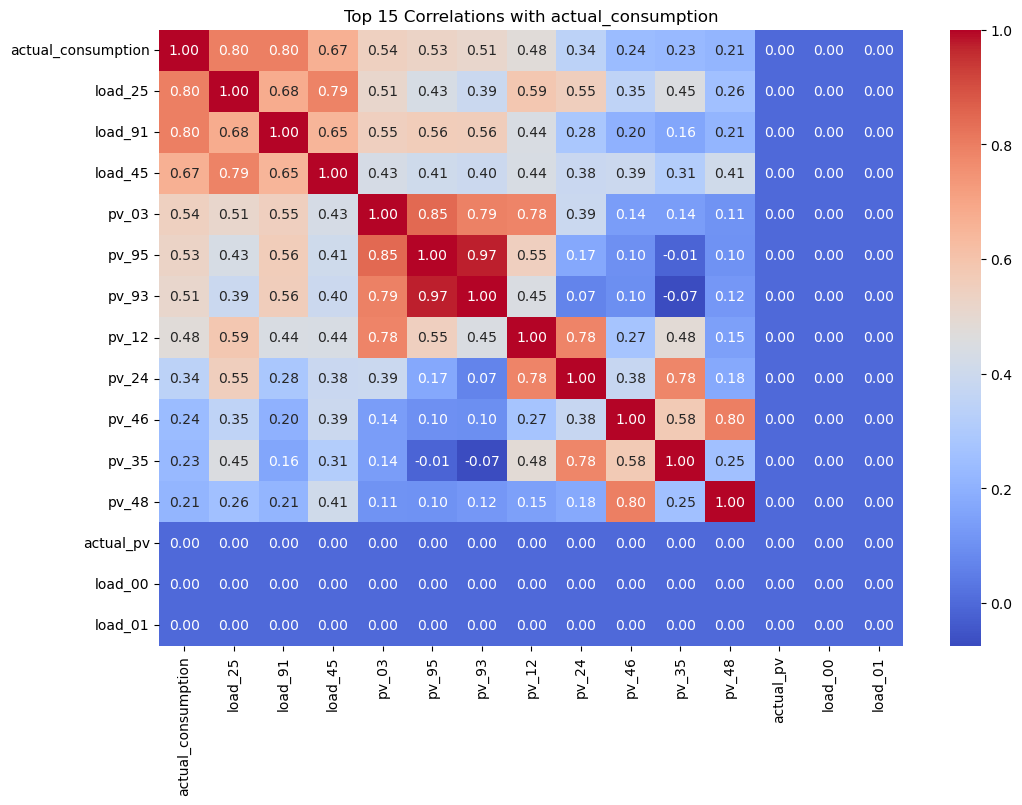

In [64]:
consump_corr_cols = filtered_correlation.nlargest(15, "actual_consumption")["actual_consumption"].index.tolist()
top_15_consump_corr = filtered_correlation.loc[consump_corr_cols, consump_corr_cols]

# Построение heatmap для топ 15 столбцов
plt.figure(figsize=(12, 8))
sns.heatmap(top_15_consump_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 15 Correlations with actual_consumption')
plt.show();

In [48]:
corr_matrix2 = corr_matrix
columns_to_drop = ["load_{:02d}".format(i) for i in range(1, 14)]
corr_matrix.drop(columns=columns_to_drop, inplace=True)
corr_matrix.drop(index=columns_to_drop, errors='ignore', inplace=True)

KeyError: "['load_01', 'load_02', 'load_03', 'load_04', 'load_05', 'load_06', 'load_07', 'load_08', 'load_09', 'load_10', 'load_11', 'load_12', 'load_13'] not found in axis"

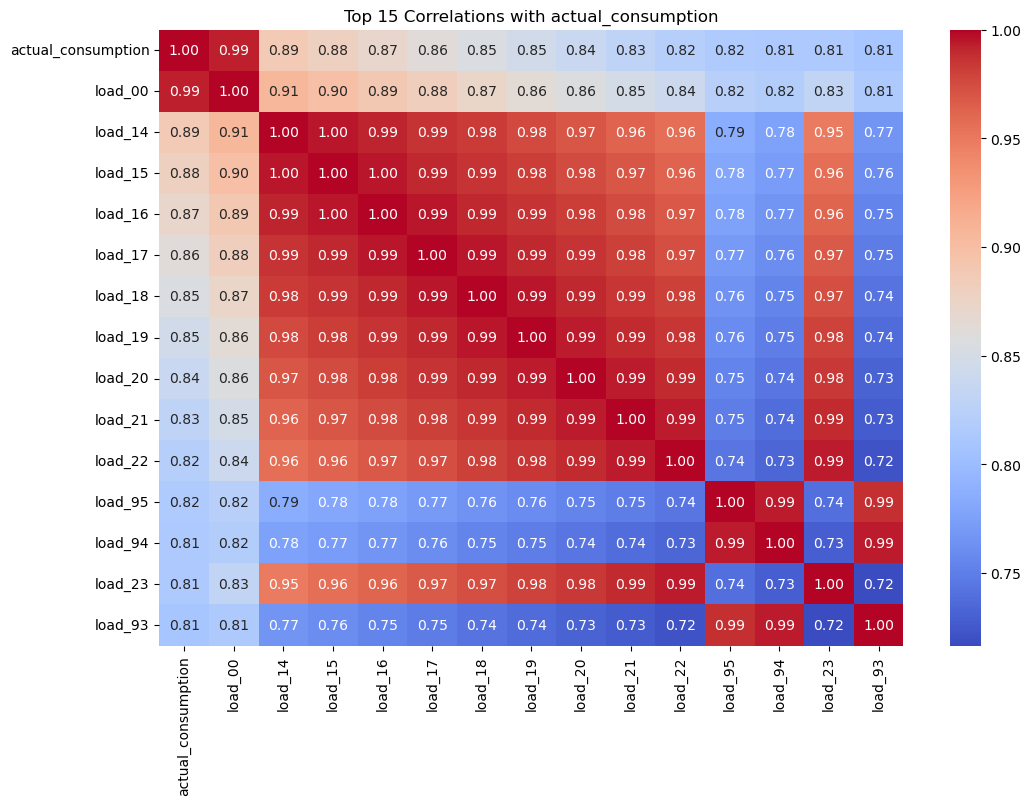

In [51]:
consump_corr_cols = corr_matrix.nlargest(15, "actual_consumption")["actual_consumption"].index.tolist()
top_15_consump_corr = corr_matrix.loc[consump_corr_cols, consump_corr_cols]

# Построение heatmap для топ 15 столбцов
plt.figure(figsize=(12, 8))
sns.heatmap(top_15_consump_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 15 Correlations with actual_consumption')
plt.show();

In [52]:
corr_matrix2 = corr_matrix
columns_to_drop = ["load_{:02d}".format(i) for i in range(14, 24)] + ["load_{:02d}".format(i) for i in range(93, 96)]
corr_matrix.drop(columns=columns_to_drop, inplace=True)
corr_matrix.drop(index=columns_to_drop, errors='ignore', inplace=True)

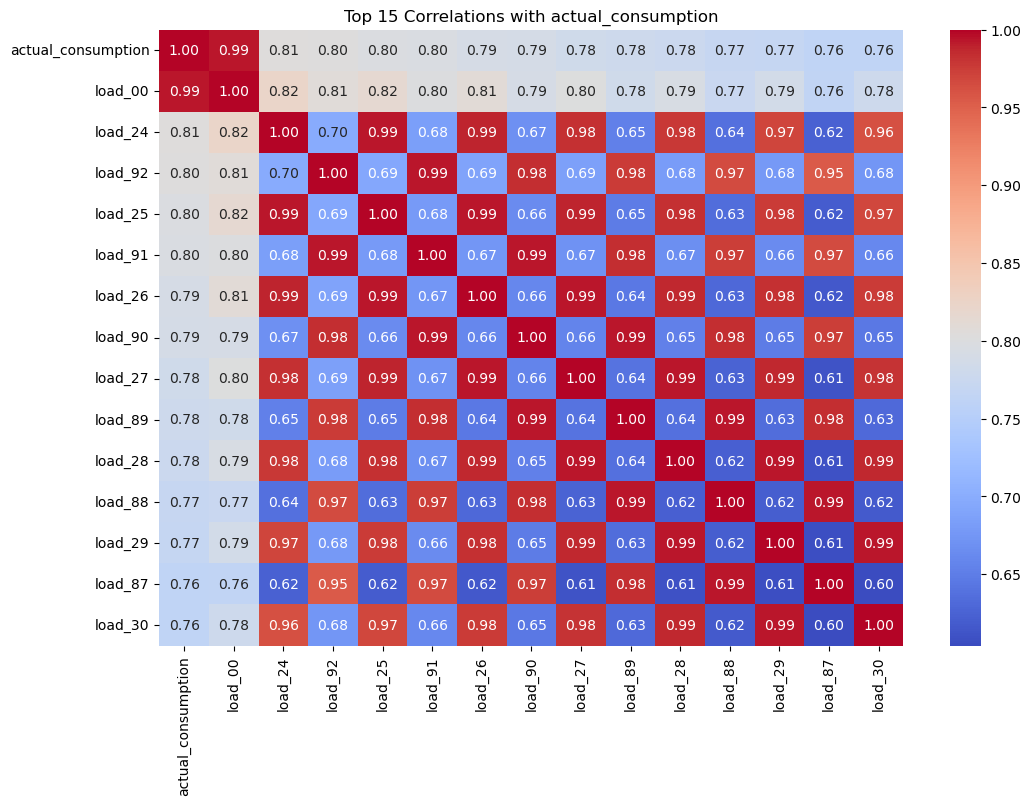

In [53]:
consump_corr_cols = corr_matrix.nlargest(15, "actual_consumption")["actual_consumption"].index.tolist()
top_15_consump_corr = corr_matrix.loc[consump_corr_cols, consump_corr_cols]

# Построение heatmap для топ 15 столбцов
plt.figure(figsize=(12, 8))
sns.heatmap(top_15_consump_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 15 Correlations with actual_consumption')
plt.show();

In [54]:
corr_matrix2 = corr_matrix
columns_to_drop = ["load_{:02d}".format(i) for i in range(24, 28)] + ["load_{:02d}".format(i) for i in range(91, 93)]
corr_matrix.drop(columns=columns_to_drop, inplace=True)
corr_matrix.drop(index=columns_to_drop, errors='ignore', inplace=True)

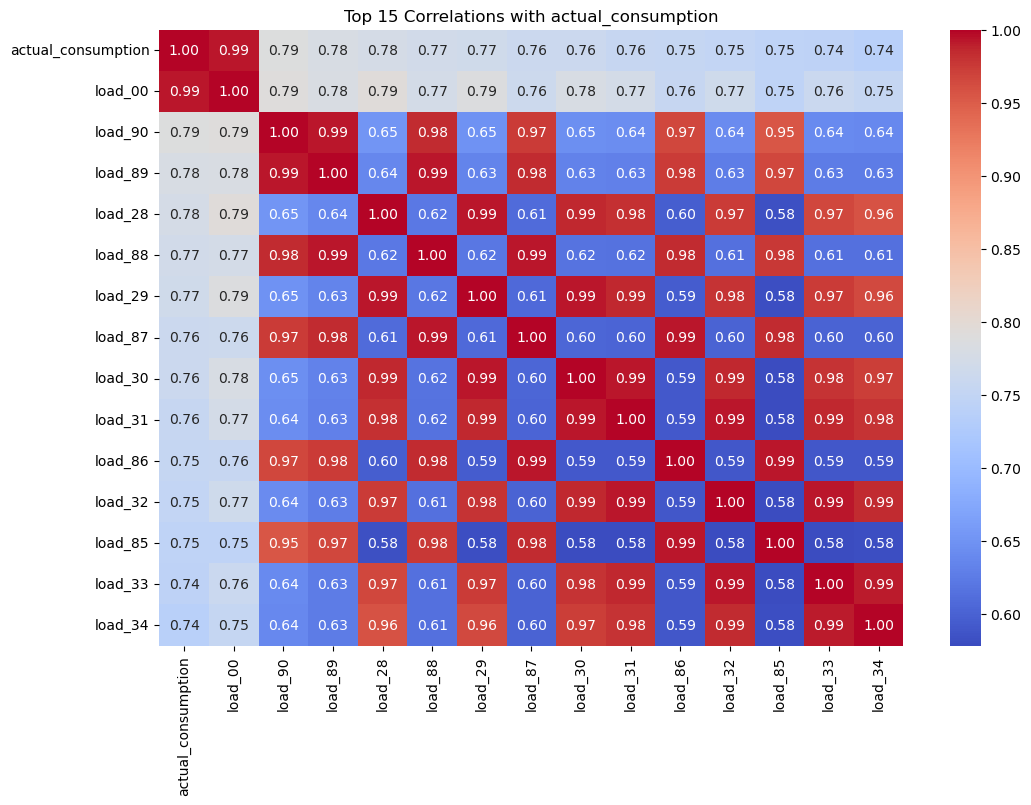

In [55]:
consump_corr_cols = corr_matrix.nlargest(15, "actual_consumption")["actual_consumption"].index.tolist()
top_15_consump_corr = corr_matrix.loc[consump_corr_cols, consump_corr_cols]

# Построение heatmap для топ 15 столбцов
plt.figure(figsize=(12, 8))
sns.heatmap(top_15_consump_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 15 Correlations with actual_consumption')
plt.show();

Второе: стандартизируем данные. Из-за разного масштаба данных, веса внутри модели будут неинтерпретируемыми. Например, чем больше значение признака, тем больше его вес

Если мы сразу отмасштабируем все данные (и обучающую, и тестовую выборки), то информация из тестовой части «утечет» в обучающую просто потому, что, в случае стандартизации, среднее и СКО будет рассчитываться на основе всех данных. Как следствие, модель на этапе обучения уже «увидит» тестовые данные, а значит качество модели «на тесте» может быть неоправданно завышено.

Для того чтобы тестовые данные никак не влияли на обучающую часть, нужно:

- рассчитать среднее и СКО обучающей выборки;
- отмасштабировать обучающие данные;
- обучить на них модель;
- использовать ранее рассчитанные среднее и СКО для масштабирования тестовых данных;
- сделать прогноз на отмасштабированных тестовых данных и оценить качество модели.

## 2. Градиентный бустинг (GBM)